In [124]:
using NPZ
using Interpolations
using Cubature
using PyCall
using LinearAlgebra
using BenchmarkTools
using PyPlot
using QuadGK
include("xray_3dphc.jl")
numpy = pyimport("numpy")

PyObject <module 'numpy' from '/home/elinas/miniconda3/envs/mp/lib/python3.7/site-packages/numpy/__init__.py'>

## FCC 1BZ

In [2]:
X = [0, 1/2, 1/2]
L = [1/2, 1/2, 1/2]
W = [[1/4], [3/4], [1/2]]
U = [[1/4], [5/8], [5/8]]
d = [0.1, 0, 0]
d2x = [0.1 0 0]
d2y = [0 0.1 0]
d2z = [0 0 0.1]

X .- d
oo1bz1 = [1 -1 1]
L2 = transpose(L)

1×3 Transpose{Float64,Array{Float64,1}}:
 0.5  0.5  0.5

In [3]:
reshape(Wm, 1, 3)

LoadError: UndefVarError: Wm not defined

In [4]:
cartesian_to_FCC_recip * [1/4, 1, 1/4]

3-element Array{Float64,1}:
 0.25
 0.625
 0.625

In [5]:
FCC_to_cartesian_recip * (X)

3-element Array{Float64,1}:
 0.0
 1.0
 0.0

In [6]:
Xm = X .- d
println(in_1BZ_FCC(Xm))
println(in_1BZ_FCC((FCC_to_cartesian_recip * X) .+ 3*d))
println(in_1BZ_FCC(FCC_to_cartesian_recip * (L .+ d)))
println(in_1BZ_FCC(FCC_to_cartesian_recip * (L .- d)))

true
true
false
true


In [7]:
in_1BZ_FCC_2(transpose(FCC_to_cartesian_recip * X) .+ d2y)

false

In [8]:
vec_options[14] == [0 0 0]

true

In [9]:
function in_1BZ_FCC_2(k)
#     println("norm(k): ", string(norm(k)))
    for v in vec_options
        if v == [0 0 0]
#             println("0")
        else
#             println("v: ", string(v))
#             println("k .- v: ", string(k .- v))
#             println("norm k .- v: ", string(norm(k .- v)))
            if norm(k .- v) < norm(k)
                return false
            end
        end
    end
    return true
end  

in_1BZ_FCC_2 (generic function with 1 method)

In [10]:
v1 = [0.1, 0.1, 0.1]
k0x = v1[1]
k0y = v1[2]
k0z = v1[3]
b1 = FCC_recip_basis[1]

1×3 Array{Int64,2}:
 1  -1  1

In [11]:
bring_into_1BZ_FCC(k0x + b1[1], k0y + b1[2], k0z + b1[3])

([0.10000000000000009, 0.10000000000000003, 0.10000000000000003], [-1, 0, 0])

## 1D PhCs

In [18]:
ωp = 1e19
ωi = 2e15
ωs = ωp - ωi
#dmnd and ln
# g = 3.1e10 #being approximate here
# ga
g = 1.95e10
gvec = g * [0,0,1]
θB = asin(g*c/(2*ωp))
# println(θB)

# χ = 2e-17 #dmmd
# χ = 1.3e-13 # LN
χ = 4.7e-14 # GA
np = 1e14
# a = 0.5e-6 #PhC lattice spacing
a = 0.5e-6 # free space lattice spacing.... get more accurate modes??
L = 1e-4 #1mm where period is micron scale sounds reasonable

θdev = 0.001
ϕdev = 0.0025
P = PumpBeam(ωp, θB, 0.0)

PumpBeam(1.0e19, 0.29662806479241327, 0.0)

In [3]:
data = npzread("phc_an_files/phc1d_fs_largek_kpar_te_ga.npz")

kBZ = data["arr_0"]
Δk = kBZ[2] - kBZ[1]
krange = range(-0.5, 0.5, length=25)


M1dat = data["arr_1"]
M2dat = data["arr_2"]
ωdat = data["arr_3"]
vgdat = data["arr_4"];

Nb = size(ωdat)[1]
NM = size(M1dat)[4]
Nk = size(ωdat)[2]
ks = range(-0.5,0.5,length=70);
ωsplines = Array{Any,1}(undef, Nb)
k0 = Integer((Nk+1)/2) # Nk must be odd

for b in 1:Nb
    ωband = ωdat[b,:,:]
    ωitp = interpolate(ωband, BSpline(Quadratic(Flat(OnCell()))));
    ωsitp = scale(ωitp, krange, krange.*8);
    ωsplines[b] = ωsitp
end
Msplines = Array{Any,3}(undef, Nb, NM, 2)
for i in 1:2
    key = string("arr_", i)
    Mdat = data[key]
    for b in 1:Nb
        for nz in 1:NM
            Mitp = interpolate(Mdat[b,:,:,nz], BSpline(Quadratic(Flat(OnCell()))));
            Msitp = scale(Mitp, krange, krange.*8);
            Msplines[b,nz,i] = Msitp
        end
    end
end


D_te = PhC_Data(a, Msplines, ωsplines, 0);
data = npzread("phc_an_files/phc1d_fs_largek_kpar_tm_ga.npz")

kBZ = data["arr_0"]
Δk = kBZ[2] - kBZ[1]
krange = range(-0.5, 0.5, length=25)


M1dat = data["arr_1"]
M2dat = data["arr_2"]
ωdat = data["arr_3"]
vgdat = data["arr_4"];

Nb = size(ωdat)[1]
NM = size(M1dat)[4]
Nk = size(ωdat)[2]
ks = range(-0.5,0.5,length=70);
ωsplines = Array{Any,1}(undef, Nb)
k0 = Integer((Nk+1)/2) # Nk must be odd

for b in 1:Nb
    ωband = ωdat[b,:,:]
    ωitp = interpolate(ωband, BSpline(Quadratic(Flat(OnCell()))));
    ωsitp = scale(ωitp, krange, krange.*8);
    ωsplines[b] = ωsitp
end
Msplines = Array{Any,3}(undef, Nb, NM, 2)
for i in 1:2
    key = string("arr_", i)
    Mdat = data[key]
    for b in 1:Nb
        for nz in 1:NM
            Mitp = interpolate(Mdat[b,:,:,nz], BSpline(Quadratic(Flat(OnCell()))));
            Msitp = scale(Mitp, krange, krange.*8);
            Msplines[b,nz,i] = Msitp
        end
    end
end


D_tm = PhC_Data(a, Msplines, ωsplines, 0);

## Matching up nicely
(some off-by-one errors)

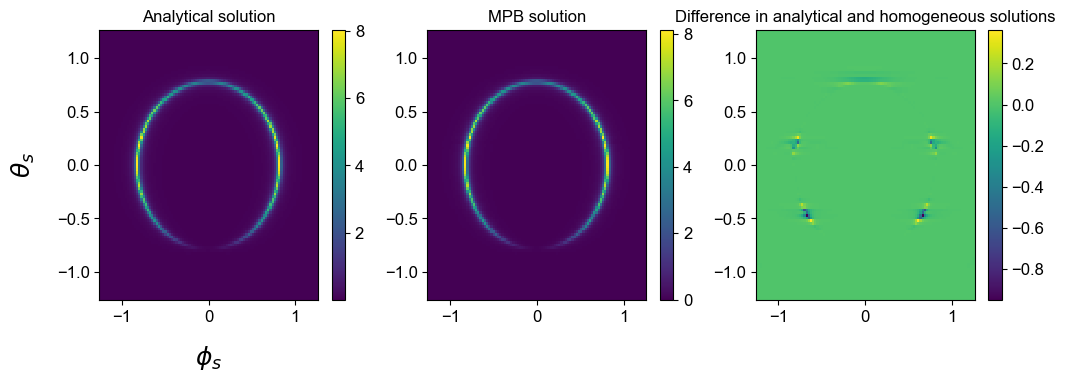

PyObject <matplotlib.colorbar.Colorbar object at 0x7f0df1e99650>

In [4]:
ωi = 2.2/ħeV #2/ħeV
Nangles = 100
θdev = 0.00125
ϕdev = 0.00125
dat = zeros(Nangles,Nangles)
θrange = range(θB - θdev, θB + θdev, length=Nangles)
ϕrange = range(-ϕdev, ϕdev, length=Nangles)
Δθ = θrange[2]-θrange[1]
Δϕ = ϕrange[2]-ϕrange[1]
b = 4

# Threads.@threads for b in 1:6
#     newdat = [dΓdωdΩ_1D_analytical_1(ωp - ωi, θs, ϕs, gvec, P, D_tm_fs, χ, np, L, b, lz=0.6e14, pol="tm")*cos(θs)
#                             for θs in θrange, ϕs in ϕrange]
#     global dat2 .+= newdat
# end
Threads.@threads for b in 1:1
    newdat = [dΓdωdΩ_free(ωp - ωi, θs, ϕs, gvec, P, 13/2, χ, np, L, lz=0.6e14, pol="tm")*cos(θs)
                        for θs in θrange, ϕs in ϕrange]
    global dat .+= newdat
end

subplots(1,3, figsize=(12, 3.5))
title("TM Modes at 2.2 eV")
subplot(1,3,1)
title("Analytical solution")
pcolormesh(ϕrange.*1000, (θrange.-θB).*1000, dat)
xlabel(L"$ϕ_s$", fontsize=18.0, labelpad=14.0)
ylabel(L"$θ_s$", fontsize=18.0, labelpad=14)
colorbar()

subplot(1,3,2)
dat2 = zeros(Nangles, Nangles)

Threads.@threads for b in 1:6
    newdat = [dΓdωdΩ_1D(ωp - ωi, θs, ϕs, gvec, P, D_tm, χ, np, L, b, lz=0.6e14, pol="tm")*cos(θs)
                        for θs in θrange, ϕs in ϕrange]
    global dat2 .+= newdat
end

pcolormesh(ϕrange.*1000, (θrange.-θB).*1000, dat2)
title("MPB solution")
# xlabel(L"$ϕ_s$", fontsize=18.0, labelpad=14.0)
# ylabel(L"$θ_s$", fontsize=18.0, labelpad=14)
colorbar()


subplot(1,3,3)
title("Difference in analytical and homogeneous solutions")
pcolormesh(ϕrange.*1000, (θrange.-θB).*1000, dat2 .- dat)
# xlabel(L"$ϕ_s$", fontsize=18.0, labelpad=14.0)
# ylabel(L"$θ_s$", fontsize=18.0, labelpad=14)
colorbar()

In [17]:
1/(13/2)

0.15384615384615385

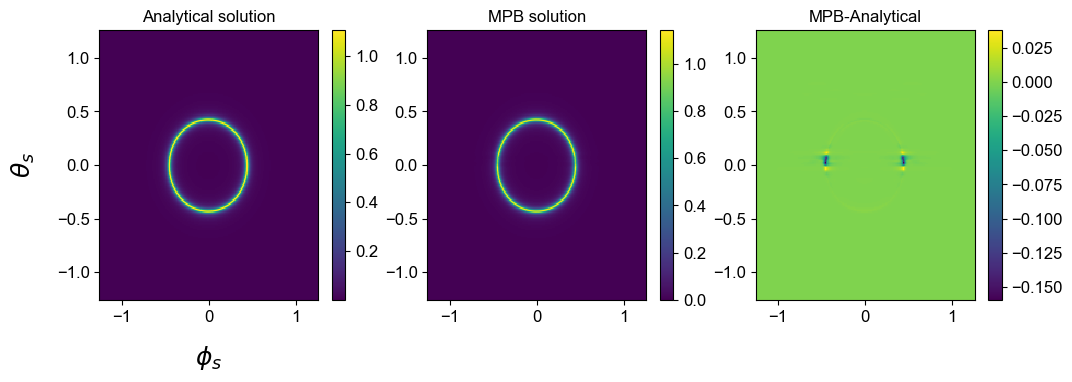

PyObject <matplotlib.colorbar.Colorbar object at 0x7fd28ec14490>

In [30]:
ωi = 1.2/ħeV #2/ħeV
Nangles = 200
θdev = 0.00125
ϕdev = 0.00125
dat = zeros(Nangles,Nangles)
θrange = range(θB - θdev, θB + θdev, length=Nangles)
ϕrange = range(-ϕdev, ϕdev, length=Nangles)
Δθ = θrange[2]-θrange[1]
Δϕ = ϕrange[2]-ϕrange[1]
b = 4

# Threads.@threads for b in 1:6
#     newdat = [dΓdωdΩ_1D_analytical_1(ωp - ωi, θs, ϕs, gvec, P, D_tm_fs, χ, np, L, b, lz=0.6e14, pol="tm")*cos(θs)
#                             for θs in θrange, ϕs in ϕrange]
#     global dat2 .+= newdat
# end

# what info_free returns:
#      1     2       3                      4            5                               6         7
# prefactor, ωi, lor(ωp - ωs - ωi, lz), idler_pol, (sum(kivec.*normalize(gvec))/ki)^2, kivec, sum(kpvec.* gvec)

dat = [(dΓdωdΩ_free(ωp - ωi, θs, ϕs, gvec, P, 13/2, χ/2, np, L, lz=0.6e14, pol="te")*cos(θs) +
       dΓdωdΩ_free(ωp - ωi, θs, ϕs, gvec, P, 13/2, χ/2, np, L, lz=0.6e14, pol="tm")*cos(θs))
                    for θs in θrange, ϕs in ϕrange]
npzwrite("phc_an_files/ang_spec_1dphc_fs_ga_1-2.npz", dat)

subplots(1,3, figsize=(12, 3.5))
subplot(1,3,1)
title("Analytical solution")
pcolormesh(ϕrange.*1000, (θrange.-θB).*1000, dat)
xlabel(L"$ϕ_s$", fontsize=18.0, labelpad=14.0)
ylabel(L"$θ_s$", fontsize=18.0, labelpad=14)
colorbar()

subplot(1,3,2)
dat2 = zeros(Nangles, Nangles)

# what info_1D returns
#  1    2             3            4    5      6       7        8       9    10    11       12
# ωi, M0^2, lor(ωp - ωs - ωi, lz), kB, k0x, noffset, kivec, polfactor, k0y, kiz, k0par, prefactor
Threads.@threads for b in 1:6
    newdat = [(dΓdωdΩ_1D(ωp - ωi, θs, ϕs, gvec, P, D_te, χ/2, np, L, b, lz=0.6e14, pol="te")*cos(θs) +
               dΓdωdΩ_1D(ωp - ωi, θs, ϕs, gvec, P, D_tm, χ/2, np, L, b, lz=0.6e14, pol="tm")*cos(θs))
                        for θs in θrange, ϕs in ϕrange]
    global dat2 .+= newdat
end
# npzwrite("phc_an_files/ang_spec_1dphc_fs_ga_1-9.npz", dat2)
pcolormesh(ϕrange.*1000, (θrange.-θB).*1000, dat2)
title("MPB solution")
# xlabel(L"$ϕ_s$", fontsize=18.0, labelpad=14.0)
# ylabel(L"$θ_s$", fontsize=18.0, labelpad=14)
colorbar()


subplot(1,3,3)
title("MPB-Analytical")
pcolormesh(ϕrange.*1000, (θrange.-θB).*1000, dat2 .- dat)
# xlabel(L"$ϕ_s$", fontsize=18.0, labelpad=14.0)
# ylabel(L"$θ_s$", fontsize=18.0, labelpad=14)
colorbar()

In [26]:
sum(dat)

4055.0600349351575

In [46]:
Nω = 30
Emax = 3.0
fspec_1d_fs_a_tm = dηdω_free(Nω, Emax, 13/2, P, gvec, χ, np, L, Nangles=300, lz=0.6e14, θdev=0.00175, ϕdev=0.00175, pol="tm")
fspec_1d_fs_a_te = dηdω_free(Nω, Emax, 13/2, P, gvec, χ, np, L, Nangles=300, lz=0.6e14, θdev=0.00175, ϕdev=0.00175, pol="te")
fspec_1d_te = dηdω(Nω, Emax, P, D_te, "1D", gvec, χ, np, L, Nangles=150, lz=1.3e14, θdev=0.002, ϕdev=0.002, pol="te", Nb=6)
fspec_1d_tm = dηdω(Nω, Emax, P, D_tm, "1D", gvec, χ, np, L, Nangles=150, lz=1.3e14, θdev=0.002, ϕdev=0.002, pol="tm", Nb=6)


omega i = 1
omega i = 2
omega i = 3
omega i = 4
omega i = 5
omega i = 6
omega i = 7
omega i = 8
omega i = 9
omega i = 10
omega i = 11
omega i = 12
omega i = 13
omega i = 14
omega i = 15
omega i = 16
omega i = 17
omega i = 18
omega i = 19
omega i = 20
omega i = 21
omega i = 22
omega i = 23
omega i = 24
omega i = 25
omega i = 26
omega i = 27
omega i = 28
omega i = 29
omega i = 30
omega i = 1
omega i = 2
omega i = 3
omega i = 4
omega i = 5
omega i = 6
omega i = 7
omega i = 8
omega i = 9
omega i = 10
omega i = 11
omega i = 12
omega i = 13
omega i = 14
omega i = 15
omega i = 16
omega i = 17
omega i = 18
omega i = 19
omega i = 20
omega i = 21
omega i = 22
omega i = 23
omega i = 24
omega i = 25
omega i = 26
omega i = 27
omega i = 28
omega i = 29
omega i = 30
phidev = 0.0018299169928324426
θp = 0.29662806479241327
omega i = 1
omega i = 2
omega i = 3
omega i = 4
omega i = 5
omega i = 6
omega i = 7
omega i = 8
omega i = 9
omega i = 10
omega i = 11
omega i = 12
omega i = 13
omega i = 14
omega i =

30-element Array{Float64,1}:
 7.466881872728183e-25
 1.6803787837192723e-23
 4.8484752763846153e-23
 9.835034295945579e-23
 1.6762039176509858e-22
 2.536222817228678e-22
 3.572103990013643e-22
 4.788591593260945e-22
 6.181952731980004e-22
 7.781156953004509e-22
 9.559295140599599e-22
 1.1510365421180239e-21
 1.3646472462920744e-21
 ⋮
 3.034072159173666e-21
 3.380178821758622e-21
 3.739305507229351e-21
 4.108791410064343e-21
 4.473169155890402e-21
 4.88281205955981e-21
 5.311240664884295e-21
 5.756503239896567e-21
 6.2282813878117464e-21
 6.722015531452741e-21
 7.22383133880261e-21
 7.722221227147426e-21

In [47]:
ωrange = range(0, Emax, length=Nω)

0.0:0.10344827586206896:3.0

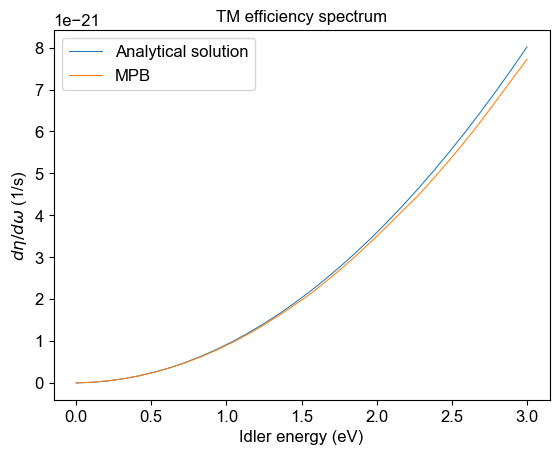

PyObject Text(29.000000000000007, 0.5, '$dη/dω$ (1/s)')

In [48]:
plot(ωrange, fspec_1d_fs_a_tm[1], label="Analytical solution")
plot(ωrange, fspec_1d_tm, label="MPB")
legend()
title("TM efficiency spectrum")
xlabel("Idler energy (eV)")
ylabel(L"$dη/dω$ (1/s)")

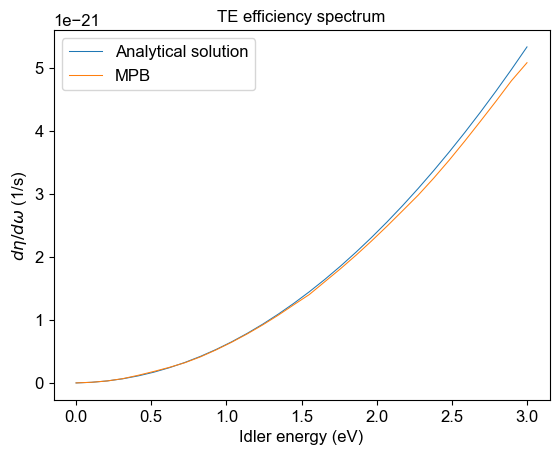

PyObject Text(29.000000000000007, 0.5, '$dη/dω$ (1/s)')

In [49]:
plot(ωrange, fspec_1d_fs_a_te[1], label="Analytical solution")
plot(ωrange, fspec_1d_te, label="MPB")
legend()
title("TE efficiency spectrum")
xlabel("Idler energy (eV)")
ylabel(L"$dη/dω$ (1/s)")

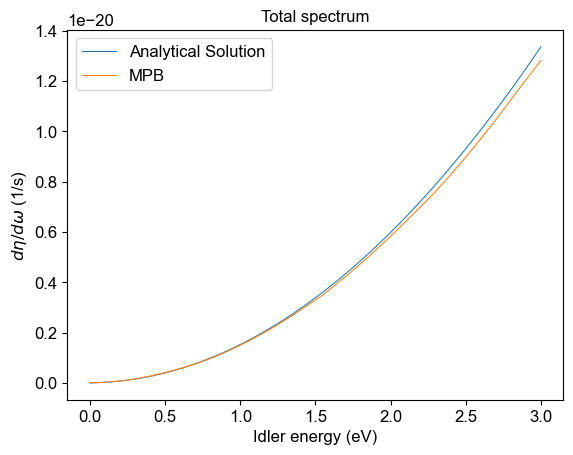

PyObject Text(29.000000000000007, 0.5, '$dη/dω$ (1/s)')

In [50]:
plot(ωrange, fspec_1d_fs_a_te[1] .+ fspec_1d_fs_a_tm[1], label="Analytical Solution")
plot(ωrange, fspec_1d_te .+ fspec_1d_tm, label="MPB")
legend()
title("Total spectrum")
xlabel("Idler energy (eV)")
ylabel(L"$dη/dω$ (1/s)")

## 3D Photonic Crystals
### SC

In [5]:
data = npzread("phc_an_files/phc3d_sc_fs_e_12_15_12b.npz")

kBZ = data["arr_0"]
Δk = kBZ[2] - kBZ[1]
krange = -0.5:Δk:0.5

M1dat = data["arr_1"]
M2dat = data["arr_2"]
M3dat = data["arr_3"]
ωdat = data["arr_4"]
vgdat = data["arr_5"];

Nb = size(ωdat)[1]
NM = size(M1dat)[5]
Nk = size(ωdat)[2]
ks = range(-0.5,0.5,length=70)
ωsplines = Array{Any,1}(undef, Nb)
k0 = Integer((Nk+1)/2) # Nk must be odd

for b in 1:Nb
    ωband = ωdat[b,:,:,:]
    ωitp = interpolate(ωband, BSpline(Quadratic(Flat(OnCell()))));
    ωsitp = scale(ωitp, krange, krange, krange);
    ωsplines[b] = ωsitp
end

Msplines = Array{Any,5}(undef, Nb, NM, NM, NM, 3)
for i in 1:3
    key = string("arr_", i)
    Mdat = data[key]
    for b in 1:Nb
        for nx in 1:NM
            for ny in 1:NM
                for nz in 1:NM
                    Mitp = interpolate(Mdat[b,:,:,:,nx,ny,nz], BSpline(Cubic(Flat(OnCell()))));
                    Msitp = scale(Mitp, krange, krange, krange);
                    Msplines[b,nx,ny,nz,i] = Msitp
                end
            end
        end
    end
end
ωp = 1e19
#dmnd and ln
# g = 3.1e10
# ga
g = 1.95e10
gvec = g * [0,0,1]
θB = asin(g*c/(2*ωp))
# println(θB)

# χ = 2e-17 #dmmd
# χ = 1.3e-13 # LN
χ = 4.7e-14 # GA
np = 1e14
a = 0.8e-7 #PhC lattice spacing
# a = 0.5e-6
L = 1e-4 #0.1mm where period is micron scale sounds reasonable

θdev = 0.0005
ϕdev = 0.0005

P = PumpBeam(1e19, θB, 0.0)
D_fs_sc = PhC_Data(a, Msplines, ωsplines, 0);

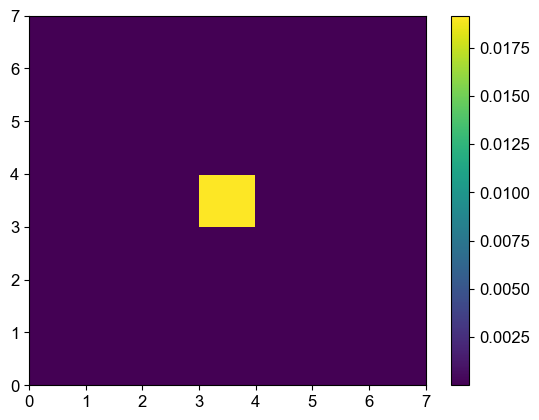

PyObject <matplotlib.colorbar.Colorbar object at 0x7f5632280950>

In [11]:
pcolormesh(M3dat[2,1,2,3,4,:,:])
colorbar()

In [10]:
krange

-0.5:0.0714285714285714:0.49999999999999956

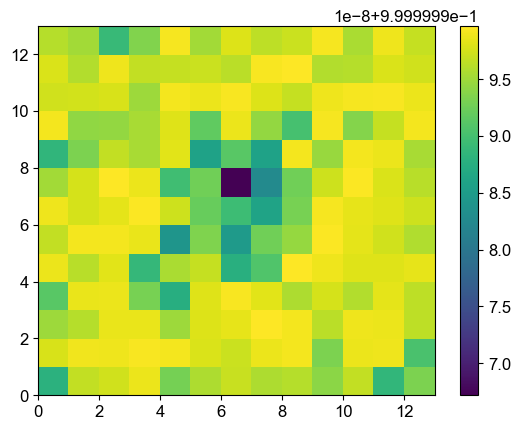

PyObject <matplotlib.colorbar.Colorbar object at 0x7f562f9de910>

In [20]:
kxi = 12
pcolormesh([(M1dat[1, kxi, ky, kz,4,4,4]^2+M2dat[1, kxi, ky, kz,4,4,4]^2+M3dat[1, kxi, ky, kz,4,4,4]^2)*12 for ky in 2:14, kz in 2:14])
# [(M1dat[2, kxi, ky, kz,4,4,4]^2+M2dat[2, kxi, ky, kz,4,4,4]^2+M3dat[2, kxi, ky, kz,4,4,4]^2)*12 for ky in 1:14, kz in 1:14])
# pcolormesh([M2dat[2, kxi, ky, kz, 4,4,4] for ky in 2:14, kz in 2:14])

colorbar()

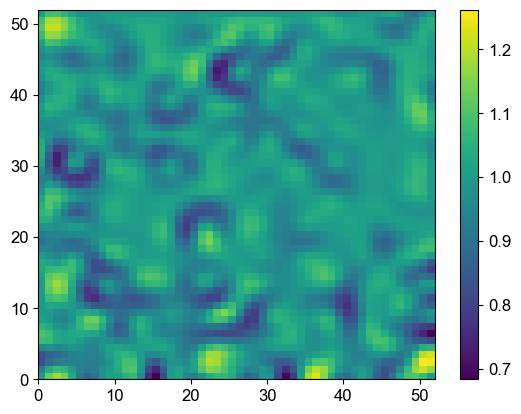

PyObject <matplotlib.colorbar.Colorbar object at 0x7f562f8d4810>

In [51]:
kx = krange[12]
krange2 = range(krange[2], krange[14], length=52)

# pcolormesh([(D_fs_sc.Mspline[2, 4, 4, 4, 1](kx, ky, kz)^2 + 
# D_fs_sc.Mspline[2, 4, 4, 4, 2](kx, ky, kz)^2 + 
# D_fs_sc.Mspline[2, 4, 4, 4, 3](kx, ky, kz)^2)*12 for ky in krange2, kz in krange2])
pcolormesh(([D_fs_sc.Mspline[2, 4, 4, 4, 3](kx, ky, kz)^2 + D_fs_sc.Mspline[2, 4, 4, 4, 2](kx, ky, kz)^2  + D_fs_sc.Mspline[2, 4, 4, 4, 1](kx, ky, kz)^2 
            for ky in krange2, kz in krange2])*12)# .-
#     [M3dat[2, kxi, ky, kz, 4,4,4]^2 +
#      M2dat[2, kxi, ky, kz, 4,4,4]^2 + M1dat[2, kxi, ky, kz, 4,4,4]^2 for ky in 1:15, kz in 1:15]))
# Msplines = [D_fs_sc.Mspline[2, Integer(4), Integer(4), Integer(4),i] for i in 1:3]
# pcolormesh([sum(([Msplines[i](kx, k0y, k0z) for i in 1:3].* normalize([1, 1, 1])).^2)*12 for k0y in krange2, k0z in krange2])

# pcolormesh([D_fs_sc.Mspline[2, 4, 4, 4, 2](kx, ky, kz) for ky in krange2, kz in krange2])

colorbar()

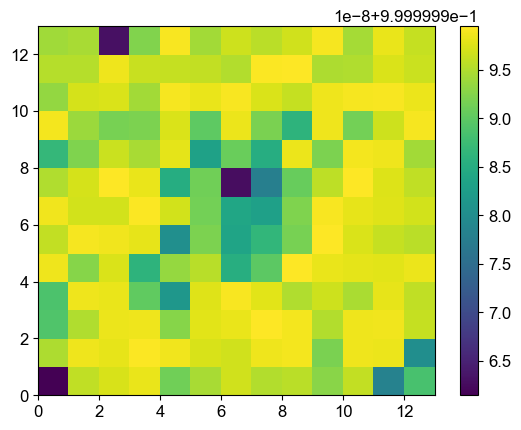

PyObject <matplotlib.colorbar.Colorbar object at 0x7f5698b41490>

In [18]:
kx = krange[12]
krange2 = range(krange[2], krange[14], length=13)

# pcolormesh([(D_fs_sc.Mspline[2, 4, 4, 4, 1](kx, ky, kz)^2 + 
# D_fs_sc.Mspline[2, 4, 4, 4, 2](kx, ky, kz)^2 + 
# D_fs_sc.Mspline[2, 4, 4, 4, 3](kx, ky, kz)^2)*12 for ky in krange2, kz in krange2])
pcolormesh(([D_fs_sc.Mspline[2, 4, 4, 4, 3](kx, ky, kz)^2 + D_fs_sc.Mspline[2, 4, 4, 4, 2](kx, ky, kz)^2  + D_fs_sc.Mspline[2, 4, 4, 4, 1](kx, ky, kz)^2 
            for ky in krange2, kz in krange2])*12)# .-
#     [M3dat[2, kxi, ky, kz, 4,4,4]^2 +
#      M2dat[2, kxi, ky, kz, 4,4,4]^2 + M1dat[2, kxi, ky, kz, 4,4,4]^2 for ky in 1:15, kz in 1:15]))

# pcolormesh([D_fs_sc.Mspline[2, 4, 4, 4, 2](kx, ky, kz) for ky in krange2, kz in krange2])

colorbar()

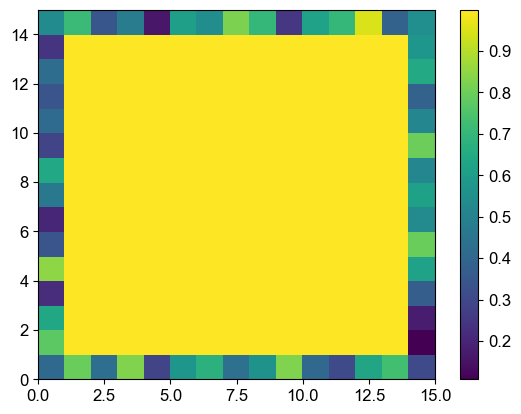

PyObject <matplotlib.colorbar.Colorbar object at 0x7f2137ae1510>

In [14]:
kxi = 12
pcolormesh([(M1dat[1, kxi, ky, kz,4,4,4]^2+M2dat[1, kxi, ky, kz,4,4,4]^2+M3dat[1, kxi, ky, kz,4,4,4]^2)*12 for ky in 1:15, kz in 1:15])
# [(M1dat[2, kxi, ky, kz,4,4,4]^2+M2dat[2, kxi, ky, kz,4,4,4]^2+M3dat[2, kxi, ky, kz,4,4,4]^2)*12 for ky in 1:14, kz in 1:14])
# pcolormesh([M2dat[2, kxi, ky, kz, 4,4,4] for ky in 2:14, kz in 2:14])

colorbar()

## The problem is the bands are messed up

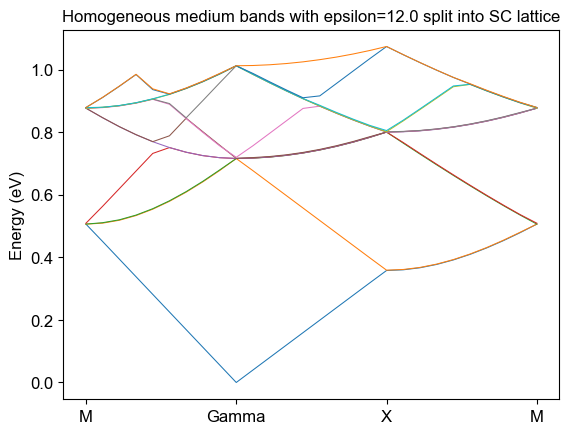

PyObject Text(0.5, 1.0, 'Homogeneous medium bands with epsilon=12.0 split into SC lattice')

In [47]:
bands_sc = npzread("phc_an_files/phc3d_sc_fs_bands_e_12_12.npz")["arr_0"]
plt.plot(bands_sc* 2π* c /a * ħeV)
plt.xticks([0, 9, 18, 27], ["M", "Gamma", "X", "M"])
plt.ylabel("Energy (eV)")
plt.title("Homogeneous medium bands with epsilon=12.0 split into SC lattice")

### Below the funky business at ~0.3 eV the MPB solution matches up pretty well

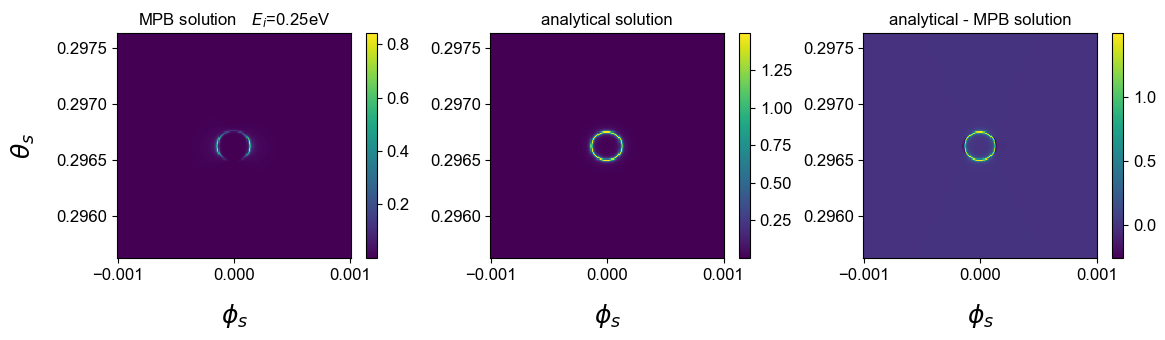

In [49]:
ωi = 0.25/ħeV #2/ħeV
Nangles = 200
dat = zeros(Nangles,Nangles)
θrange = range(θB - θdev, θB + θdev, length=Nangles)
ϕrange = range(-ϕdev, ϕdev, length=Nangles)
Δθ = θrange[2]-θrange[1]
Δϕ = ϕrange[2]-ϕrange[1]

#    1              2       3  4    5    6     7       8      9
# noffset, k0_vec_no_unit, M0, ωi, lor, Ep2, prefac, kbvec, Msplines
Threads.@threads for b in 1:12
    newdat = [dΓdωdΩ_SC(ωp - ωi, θs, ϕs, g*[1, 0, 0], P, D_fs_sc, χ, np, L, b)*cos(θs)
                        for θs in θrange, ϕs in ϕrange]
    global dat .+= newdat
end
# dat = [info_stitch_BCC(ωp - ωi, θs, ϕs, gvec, P, D_bcc, χ, np, L, 6)[6]
#                         for θs in θrange, ϕs in ϕrange]


subplots(1,3, figsize=(12, 3.5))
subplot(1,3,1)
pcolormesh(ϕrange, θrange, dat)
title(L"MPB solution $~~E_i$=0.25eV")
xlabel(L"$ϕ_s$", fontsize=18.0, labelpad=14.0)
ylabel(L"$θ_s$", fontsize=18.0, labelpad=14)
colorbar()


dat2 = [(dΓdωdΩ_free(ωp - ωi, θs, ϕs, gvec, P, 12, χ, np, L, pol="te")*cos(θs)
        + dΓdωdΩ_free(ωp - ωi, θs, ϕs, gvec, P, 12, χ, np, L, pol="tm")*cos(θs))
                    for θs in θrange, ϕs in ϕrange]
# dat = [info_stitch_BCC(ωp - ωi, θs, ϕs, gvec, P, D_bcc, χ, np, L, 6)[6]
#                         for θs in θrange, ϕs in ϕrange]

subplot(1,3,2)
pcolormesh(ϕrange, θrange, dat2)
title("analytical solution")
xlabel(L"$ϕ_s$", fontsize=18.0, labelpad=14.0)
colorbar()

subplot(1,3,3)
pcolormesh(ϕrange, θrange, dat2 .- dat)
title("analytical - MPB solution")
xlabel(L"$ϕ_s$", fontsize=18.0, labelpad=14.0)
colorbar()

tight_layout()

## an 8% difference in the rate

In [25]:
(sum(dat2) - sum(dat))/sum(dat2)

0.12328054635169551

## above 0.3 eV though, there is a large discrepancy

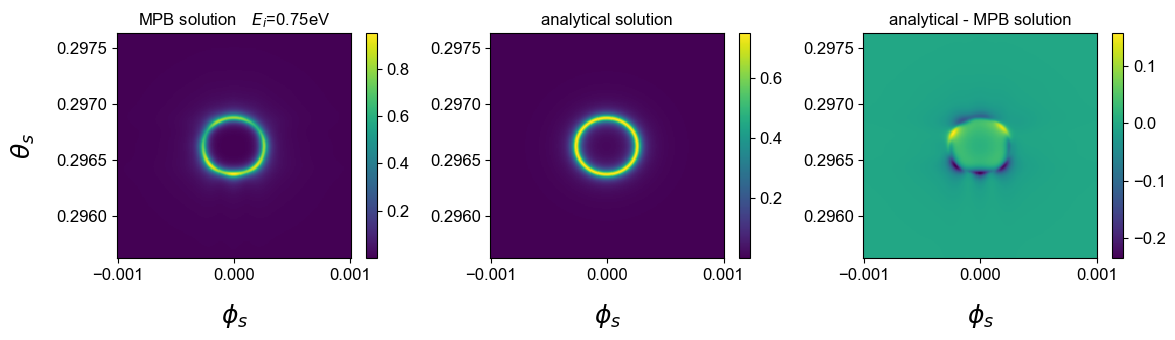

In [140]:
θdev = 0.001
ϕdev = 0.001
ωi = 0.5/ħeV #2/ħeV
Nangles = 200
dat = zeros(Nangles,Nangles)
θrange = range(θB - θdev, θB + θdev, length=Nangles)
ϕrange = range(-ϕdev, ϕdev, length=Nangles)
Δθ = θrange[2]-θrange[1]
Δϕ = ϕrange[2]-ϕrange[1]

#    1              2       3  4    5    6     7       8      9
# noffset, k0_vec_no_unit, M0, ωi, lor, Ep2, prefac, kbvec, Msplines
Threads.@threads for b in 1:12
    newdat = [dΓdωdΩ_SC(ωp - ωi, θs, ϕs, g*[1, 0, 0], P, D_fs_sc, χ, np, L, b, lz=0.8e14)*cos(θs)/sqrt(3)
                        for θs in θrange, ϕs in ϕrange]
    global dat .+= newdat
end
# dat = [info_stitch_BCC(ωp - ωi, θs, ϕs, gvec, P, D_bcc, χ, np, L, 6)[6]
#                         for θs in θrange, ϕs in ϕrange]


subplots(1,3, figsize=(12, 3.5))
subplot(1,3,1)
pcolormesh(ϕrange, θrange, dat)
title(L"MPB solution $~~E_i$=0.75eV")
xlabel(L"$ϕ_s$", fontsize=18.0, labelpad=14.0)
ylabel(L"$θ_s$", fontsize=18.0, labelpad=14)
colorbar()


dat2 = [(dΓdωdΩ_free(ωp - ωi, θs, ϕs, gvec, P, 12, χ, np, L, pol="all", lz=0.8e14)*cos(θs))
                    for θs in θrange, ϕs in ϕrange]
# dat = [info_stitch_BCC(ωp - ωi, θs, ϕs, gvec, P, D_bcc, χ, np, L, 6)[6]
#                         for θs in θrange, ϕs in ϕrange]

subplot(1,3,2)
pcolormesh(ϕrange, θrange, dat2)
title("analytical solution")
xlabel(L"$ϕ_s$", fontsize=18.0, labelpad=14.0)
colorbar()

subplot(1,3,3)
pcolormesh(ϕrange, θrange, dat2 .- dat)
title("analytical - MPB solution")
xlabel(L"$ϕ_s$", fontsize=18.0, labelpad=14.0)
colorbar()

tight_layout()

## difference in the rate

In [151]:
(sum(dat2) - sum(dat))/sum(dat2)

0.018144093288696362

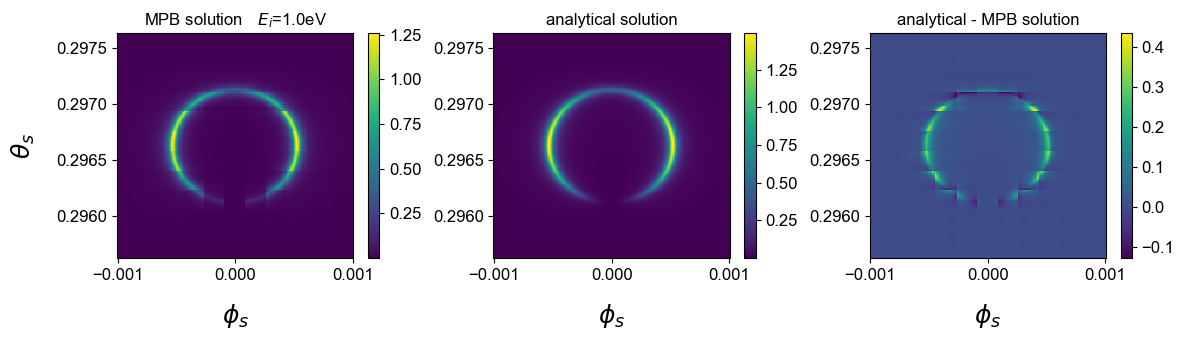

In [157]:
θdev = 0.001
ϕdev = 0.001
ωi = 1/ħeV #2/ħeV
Nangles = 200
dat = zeros(Nangles,Nangles)
θrange = range(θB - θdev, θB + θdev, length=Nangles)
ϕrange = range(-ϕdev, ϕdev, length=Nangles)
Δθ = θrange[2]-θrange[1]
Δϕ = ϕrange[2]-ϕrange[1]

#    1              2       3  4    5    6     7       8      9
# noffset, k0_vec_no_unit, M0, ωi, lor, Ep2, prefac, kbvec, Msplines
Threads.@threads for b in 1:12
    newdat = [dΓdωdΩ_SC_fs_nn(ωp - ωi, θs, ϕs, g*[1, 0, 0], P, D_fs_sc, χ, np, L, b, lz=0.8e14)*cos(θs)
                        for θs in θrange, ϕs in ϕrange]
    global dat .+= newdat
end
# dat = [info_stitch_BCC(ωp - ωi, θs, ϕs, gvec, P, D_bcc, χ, np, L, 6)[6]
#                         for θs in θrange, ϕs in ϕrange]


subplots(1,3, figsize=(12, 3.5))
subplot(1,3,1)
pcolormesh(ϕrange, θrange, dat)
title(L"MPB solution $~~E_i$=1.0eV")
xlabel(L"$ϕ_s$", fontsize=18.0, labelpad=14.0)
ylabel(L"$θ_s$", fontsize=18.0, labelpad=14)
colorbar()


dat2 = [(dΓdωdΩ_free(ωp - ωi, θs, ϕs, gvec, P, 12, χ, np, L, pol="tm", lz=0.8e14)*cos(θs))
#         + dΓdωdΩ_free(ωp - ωi, θs, ϕs, gvec, P, 12, χ, np, L, pol="te", lz=0.8e14)*cos(θs))
                    for θs in θrange, ϕs in ϕrange]
# dat = [info_stitch_BCC(ωp - ωi, θs, ϕs, gvec, P, D_bcc, χ, np, L, 6)[6]
#                         for θs in θrange, ϕs in ϕrange]

subplot(1,3,2)
pcolormesh(ϕrange, θrange, dat2)
title("analytical solution")
xlabel(L"$ϕ_s$", fontsize=18.0, labelpad=14.0)
colorbar()

subplot(1,3,3)
pcolormesh(ϕrange, θrange, dat2 .- dat)
title("analytical - MPB solution")
xlabel(L"$ϕ_s$", fontsize=18.0, labelpad=14.0)
colorbar()

tight_layout()

In [152]:
function dΓdωdΩ_SC_fs(ωs::AbstractFloat, θs::AbstractFloat, ϕs::AbstractFloat, gvec, P::PumpBeam, D::PhC_Data, χ::AbstractFloat, np::AbstractFloat, L::AbstractFloat, band::Integer, ϵbg::Real=1; lz::AbstractFloat=0.2e14)
    ωp = P.ωp
    θp = P.θp 
    ϕp = P.ϕp
    
    kp = ωp/c
    ks = ωs/c
    
    a = D.a

    kBx = -ks*sin(θs) - kp*sin(θp) + gvec[1]
    kBy = -ks*cos(θs)*sin(ϕs) + kp*cos(θp)*sin(ϕp) + gvec[2]
    kBz = - ks*cos(θs)*cos(ϕs) + kp*cos(θp)*cos(ϕp) + gvec[3]

    kBvec = [kBx, kBy, kBz]# .+ Goffset # in meters

#     k0_vec_no_unit = kBvec * a / (2π)

    k0_vec_no_unit = (kBvec * a / (2π) .+ 100.5) .% 1 .- 0.5 # in MPB units
    if !in_BZ(k0_vec_no_unit)
#         println("why are we here")
        return 0
    end
    
    noffset = -floor.(kBvec*a/(2π) .+ 0.5)
    
    # We only have mode overlap data for the first 3 offsets in all directions
    if any(abs.(noffset) .> 3)
        return 0
    end
    nx, ny, nz = -noffset .+ [4,4,4]
#     println(nx, ny, nz)

    Msplines = [D.Mspline[band, Integer(nx), Integer(ny), Integer(nz), i] for i in 1:3]

    ωspline = D.ωspline[band]
    
    k0x, k0y, k0z = k0_vec_no_unit

    ω0 = ωspline(k0x, k0y, k0z)
#     M0 = Mspline(k0x, k0y, k0z)
    M0 = sum([Msplines[i](k0x, k0y, k0z) for i in 1:3].^2 .* normalize(gvec))
#     M0 = M0[1]
#     println("M0: ", M0)

    ωi = ω0 * 2π*c / (a*sqrt(ϵbg))
    Ep2 = ħ*np*ωp/(2*ϵ0)
    prefactor = ωs^3/(16*π^2*c^3*ϵbg) * Ep2 * L^3 * χ^2
    
    return prefactor * ωi * M0 * lor(ωp - ωs - ωi, lz)
end

dΓdωdΩ_SC_fs (generic function with 2 methods)

In [116]:
function dΓdωdΩ_SC_fs_1(ωs::AbstractFloat, θs::AbstractFloat, ϕs::AbstractFloat, gvec, P::PumpBeam, D::PhC_Data, χ::AbstractFloat, np::AbstractFloat, L::AbstractFloat, band::Integer, ϵbg::Real=1; lz::AbstractFloat=0.2e14)
    ωp = P.ωp
    θp = P.θp 
    ϕp = P.ϕp
    
    kp = ωp/c
    ks = ωs/c
    
    a = D.a

    kBx = -ks*sin(θs) - kp*sin(θp) + gvec[1]
    kBy = -ks*cos(θs)*sin(ϕs) + kp*cos(θp)*sin(ϕp) + gvec[2]
    kBz = - ks*cos(θs)*cos(ϕs) + kp*cos(θp)*cos(ϕp) + gvec[3]

    kBvec = [kBx, kBy, kBz]# .+ Goffset # in meters

#     k0_vec_no_unit = kBvec * a / (2π)

    k0_vec_no_unit = (kBvec * a / (2π) .+ 100.5) .% 1 .- 0.5 # in MPB units
    if !in_BZ(k0_vec_no_unit)
#         println("why are we here")
        return 0
    end
    
    noffset = -floor.(kBvec*a/(2π) .+ 0.5)
    
    # We only have mode overlap data for the first 3 offsets in all directions
    if any(abs.(noffset) .> 3)
        return 0
    end
    nx, ny, nz = -noffset .+ [4,4,4]
#     println(nx, ny, nz)

    Msplines = [D.Mspline[band, Integer(nx), Integer(ny), Integer(nz),i] for i in 1:3]

    ωspline = D.ωspline[band]
    
    k0x, k0y, k0z = k0_vec_no_unit

    ω0 = ωspline(k0x, k0y, k0z)
#     M0 = Mspline(k0x, k0y, k0z)
#     M0 = sum(([Msplines[i](k0x, k0y, k0z) for i in 1:3].* normalize([1, 1, 1])).^2)
#     M0 = M0[1]
    M0 = 1/4.41
#     println("M0: ", M0)

    ωi = ω0 * 2π*c / (a*sqrt(ϵbg))
    Ep2 = ħ*np*ωp/(2*ϵ0)
    prefactor = ωs^3/(16*π^2*c^3*ϵbg) * Ep2 * L^3 * χ^2
    
    return prefactor * ωi * M0 * lor(ωp - ωs - ωi, lz)
#     return lor(ωp - ωs - ωi, lz)
end

dΓdωdΩ_SC_fs_1 (generic function with 2 methods)

In [156]:
function dΓdωdΩ_SC_fs_nn(ωs::AbstractFloat, θs::AbstractFloat, ϕs::AbstractFloat, gvec, P::PumpBeam, D::PhC_Data, χ::AbstractFloat, np::AbstractFloat, L::AbstractFloat, band::Integer, ϵbg::Real=1; lz::AbstractFloat=0.2e14, a::AbstractFloat=0.8e-7)
    ωp = P.ωp
    θp = P.θp 
    ϕp = P.ϕp
    
    kp = ωp/c
    ks = ωs/c
    
    a = D.a

    kBx = -ks*sin(θs) - kp*sin(θp) + gvec[1]
    kBy = -ks*cos(θs)*sin(ϕs) + kp*cos(θp)*sin(ϕp) + gvec[2]
    kBz = - ks*cos(θs)*cos(ϕs) + kp*cos(θp)*cos(ϕp) + gvec[3]

    kBvec = [kBx, kBy, kBz]# .+ Goffset # in meters

#     k0_vec_no_unit = kBvec * a / (2π)

    k0_vec_no_unit = (kBvec * a / (2π) .+ 100.5) .% 1 .- 0.5 # in MPB units
    if !in_BZ(k0_vec_no_unit)
#         println("why are we here")
        return 0
    end
    
    noffset = -floor.(kBvec*a/(2π) .+ 0.5)
    
    # We only have mode overlap data for the first 3 offsets in all directions
    if any(abs.(noffset) .> 3)
        return 0
    end
    nx, ny, nz = -noffset .+ [4,4,4]
#     println(nx, ny, nz)

    Msplines = [D.Mspline[band, Integer(nx), Integer(ny), Integer(nz),i] for i in 1:3]

    ωspline = D.ωspline[band]
    
    k0x, k0y, k0z = k0_vec_no_unit

    ω0 = ωspline(k0x, k0y, k0z)
    ik = round.(k0_vec_no_unit.*(Nk-1) .+ ((Nk+1)/2))
    k0_rounded = (ik.-((Nk+1)/2)) ./ (Nk-1)
    k0x, k0y, k0z = k0_rounded

#     M0 = Mspline(k0x, k0y, k0z)
    M0 = sum([Msplines[i](k0x, k0y, k0z) for i in 1:3].^2 .* normalize(gvec))
#     M0 = M0[1]
#     M0 = 1/12 
#     println("M0: ", M0)

    ωi = ω0 * 2π*c / (a*sqrt(ϵbg))
    Ep2 = ħ*np*ωp/(2*ϵ0)
    prefactor = ωs^3/(16*π^2*c^3*ϵbg) * Ep2 * L^3 * χ^2
    
    return prefactor * ωi * M0 * lor(ωp - ωs - ωi, lz)
end

dΓdωdΩ_SC_fs_nn (generic function with 2 methods)

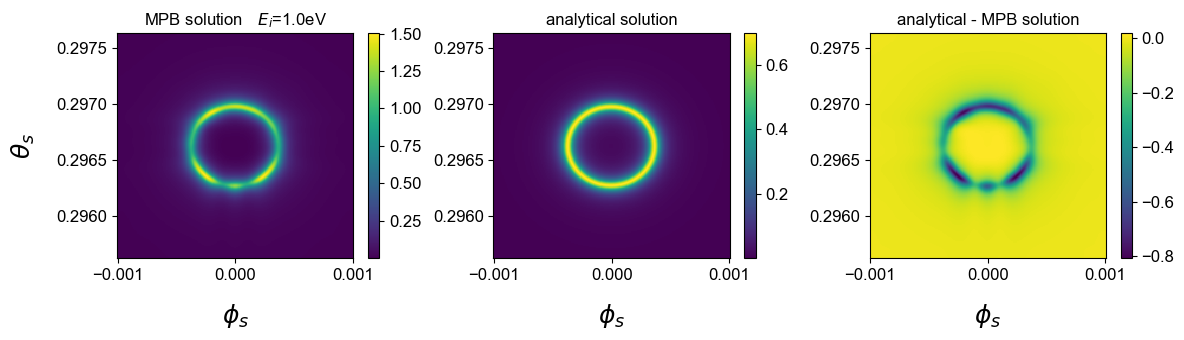

In [126]:
θdev = 0.001
ϕdev = 0.001
ωi = 0.7/ħeV #2/ħeV
Nangles = 200
dat = zeros(Nangles,Nangles)
θrange = range(θB - θdev, θB + θdev, length=Nangles)
ϕrange = range(-ϕdev, ϕdev, length=Nangles)
Δθ = θrange[2]-θrange[1]
Δϕ = ϕrange[2]-ϕrange[1]

#    1              2       3  4    5    6     7       8      9
# noffset, k0_vec_no_unit, M0, ωi, lor, Ep2, prefac, kbvec, Msplines
Threads.@threads for b in 1:12
    newdat = [dΓdωdΩ_SC(ωp - ωi, θs, ϕs, g*[1,0,0], P, D_fs_sc, χ, np, L, b, lz=1.2e14)*cos(θs)
                        for θs in θrange, ϕs in ϕrange]
    global dat .+= newdat
end
# dat = [info_stitch_BCC(ωp - ωi, θs, ϕs, gvec, P, D_bcc, χ, np, L, 6)[6]
#                         for θs in θrange, ϕs in ϕrange]


subplots(1,3, figsize=(12, 3.5))
subplot(1,3,1)
pcolormesh(ϕrange, θrange, dat)
title(L"MPB solution $~~E_i$=1.0eV")
xlabel(L"$ϕ_s$", fontsize=18.0, labelpad=14.0)
ylabel(L"$θ_s$", fontsize=18.0, labelpad=14)
colorbar()


dat2 = [(dΓdωdΩ_free(ωp - ωi, θs, ϕs, gvec, P, 12, χ, np, L, pol="all", lz=1.2e14)*cos(θs))
#         + dΓdωdΩ_free(ωp - ωi, θs, ϕs, gvec, P, 12, χ, np, L, pol="tm", lz=1.2e14)*cos(θs))
                    for θs in θrange, ϕs in ϕrange]
# dat = [info_stitch_BCC(ωp - ωi, θs, ϕs, gvec, P, D_bcc, χ, np, L, 6)[6]
#                         for θs in θrange, ϕs in ϕrange]

subplot(1,3,2)
pcolormesh(ϕrange, θrange, dat2)
title("analytical solution")
xlabel(L"$ϕ_s$", fontsize=18.0, labelpad=14.0)
colorbar()

subplot(1,3,3)
pcolormesh(ϕrange, θrange, dat2 .- dat)
title("analytical - MPB solution")
xlabel(L"$ϕ_s$", fontsize=18.0, labelpad=14.0)
colorbar()

tight_layout()

In [123]:
println(sum(dat))
println(sum(dat2))

11751.589062354986
11782.139696214479


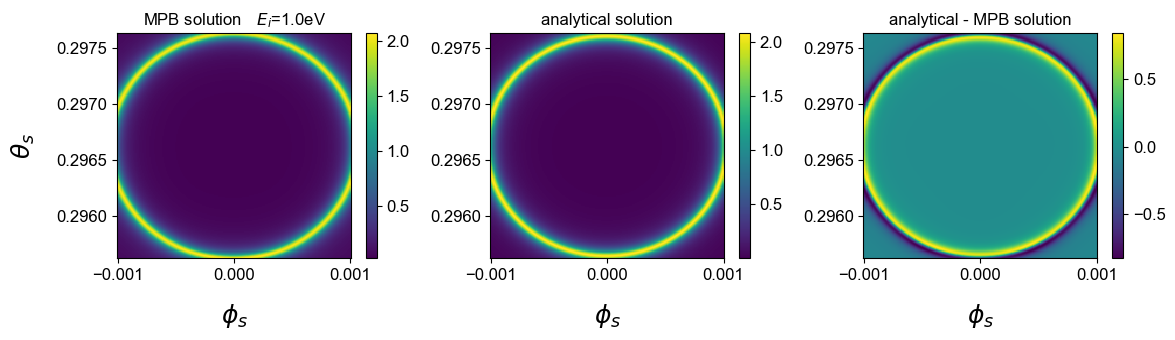

In [16]:
θdev = 0.001
ϕdev = 0.001
ωi = 2/ħeV #2/ħeV
Nangles = 200
dat = zeros(Nangles,Nangles)
θrange = range(θB - θdev, θB + θdev, length=Nangles)
ϕrange = range(-ϕdev, ϕdev, length=Nangles)
Δθ = θrange[2]-θrange[1]
Δϕ = ϕrange[2]-ϕrange[1]

#    1              2       3  4    5    6     7       8      9
# noffset, k0_vec_no_unit, M0, ωi, lor, Ep2, prefac, kbvec, Msplines
Threads.@threads for b in 1:12
    newdat = [dΓdωdΩ_SC_fs_1(ωp - ωi, θs, ϕs, gvec, P, D_fs_sc, χ, np, L, b, lz=1.2e14)*cos(θs)/2
                        for θs in θrange, ϕs in ϕrange]
    global dat .+= newdat
end
# dat = [info_stitch_BCC(ωp - ωi, θs, ϕs, gvec, P, D_bcc, χ, np, L, 6)[6]
#                         for θs in θrange, ϕs in ϕrange]


subplots(1,3, figsize=(12, 3.5))
subplot(1,3,1)
pcolormesh(ϕrange, θrange, dat)
title(L"MPB solution $~~E_i$=1.0eV")
xlabel(L"$ϕ_s$", fontsize=18.0, labelpad=14.0)
ylabel(L"$θ_s$", fontsize=18.0, labelpad=14)
colorbar()


dat2 = [(dΓdωdΩ_free(ωp - ωi, θs, ϕs, gvec, P, 11.5, χ, np, L, pol="te", lz=1.2e14)*cos(θs)
        + dΓdωdΩ_free(ωp - ωi, θs, ϕs, gvec, P, 11.5, χ, np, L, pol="tm", lz=1.2e14)*cos(θs))
                    for θs in θrange, ϕs in ϕrange]
# dat = [info_stitch_BCC(ωp - ωi, θs, ϕs, gvec, P, D_bcc, χ, np, L, 6)[6]
#                         for θs in θrange, ϕs in ϕrange]

subplot(1,3,2)
pcolormesh(ϕrange, θrange, dat2)
title("analytical solution")
xlabel(L"$ϕ_s$", fontsize=18.0, labelpad=14.0)
colorbar()

subplot(1,3,3)
pcolormesh(ϕrange, θrange, dat2 .- dat)
title("analytical - MPB solution")
xlabel(L"$ϕ_s$", fontsize=18.0, labelpad=14.0)
colorbar()

tight_layout()

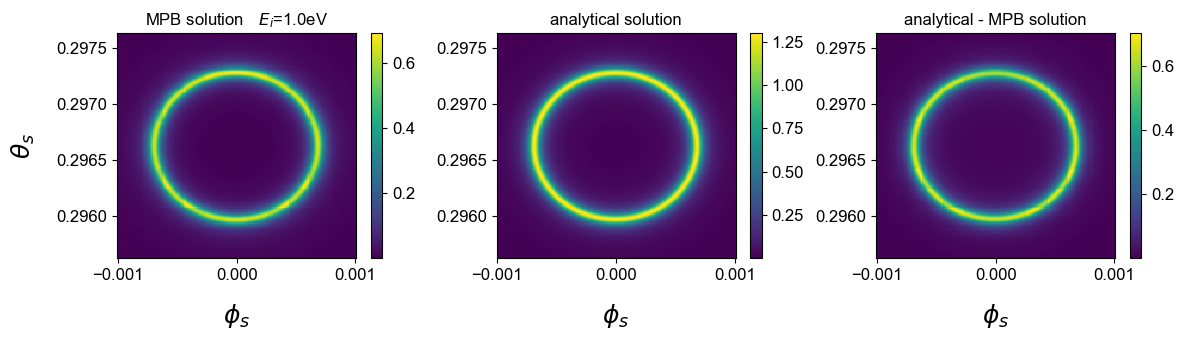

In [31]:
θdev = 0.001
ϕdev = 0.001
ωi = 1.3/ħeV #2/ħeV
Nangles = 200
dat = zeros(Nangles,Nangles)
θrange = range(θB - θdev, θB + θdev, length=Nangles)
ϕrange = range(-ϕdev, ϕdev, length=Nangles)
Δθ = θrange[2]-θrange[1]
Δϕ = ϕrange[2]-ϕrange[1]

#    1              2       3  4    5    6     7       8      9
# noffset, k0_vec_no_unit, M0, ωi, lor, Ep2, prefac, kbvec, Msplines
Threads.@threads for b in 1:12
    newdat = [dΓdωdΩ_SC_fs_nn(ωp - ωi, θs, ϕs, gvec, P, D_fs_sc, χ, np, L, b, lz=1.2e14)*cos(θs)
                        for θs in θrange, ϕs in ϕrange]
    global dat .+= newdat
end
# dat = [info_stitch_BCC(ωp - ωi, θs, ϕs, gvec, P, D_bcc, χ, np, L, 6)[6]
#                         for θs in θrange, ϕs in ϕrange]


subplots(1,3, figsize=(12, 3.5))
subplot(1,3,1)
pcolormesh(ϕrange, θrange, dat)
title(L"MPB solution $~~E_i$=1.0eV")
xlabel(L"$ϕ_s$", fontsize=18.0, labelpad=14.0)
ylabel(L"$θ_s$", fontsize=18.0, labelpad=14)
colorbar()


dat2 = [(dΓdωdΩ_free(ωp - ωi, θs, ϕs, gvec, P, 12, χ, np, L, pol="te", lz=1.2e14)*cos(θs)
        + dΓdωdΩ_free(ωp - ωi, θs, ϕs, gvec, P, 12, χ, np, L, pol="tm", lz=1.2e14)*cos(θs))
                    for θs in θrange, ϕs in ϕrange]
# dat = [info_stitch_BCC(ωp - ωi, θs, ϕs, gvec, P, D_bcc, χ, np, L, 6)[6]
#                         for θs in θrange, ϕs in ϕrange]

subplot(1,3,2)
pcolormesh(ϕrange, θrange, dat2)
title("analytical solution")
xlabel(L"$ϕ_s$", fontsize=18.0, labelpad=14.0)
colorbar()

subplot(1,3,3)
pcolormesh(ϕrange, θrange, dat2 .- dat)
title("analytical - MPB solution")
xlabel(L"$ϕ_s$", fontsize=18.0, labelpad=14.0)
colorbar()

tight_layout()

In [26]:
println(sum(dat))
println(sum(dat2))

3534.535542152383
7070.851179526757


In [51]:
D_sc_sph = read_phc_data("phc_an_files/phc3d_sc_sph_e_12_15_12b.npz", "SC", 0.5e-6);

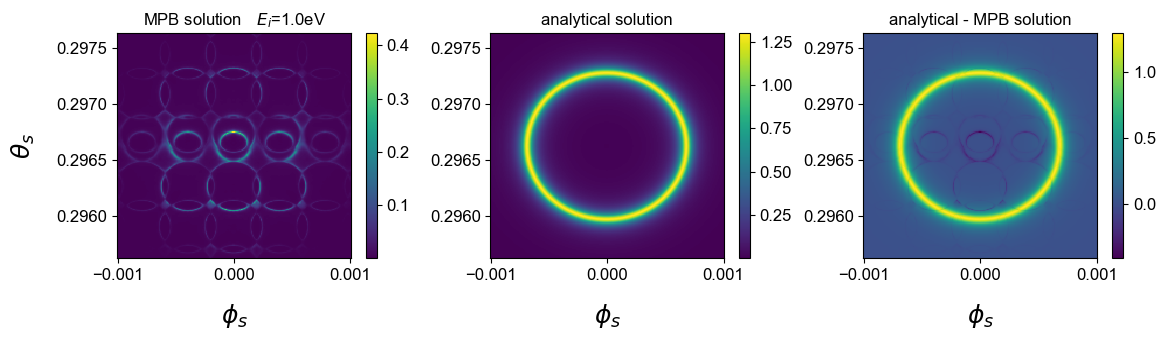

In [52]:
θdev = 0.001
ϕdev = 0.001
ωi = 1.3/ħeV #2/ħeV
Nangles = 200
dat = zeros(Nangles,Nangles)
θrange = range(θB - θdev, θB + θdev, length=Nangles)
ϕrange = range(-ϕdev, ϕdev, length=Nangles)

#    1              2       3  4    5    6     7       8      9
# noffset, k0_vec_no_unit, M0, ωi, lor, Ep2, prefac, kbvec, Msplines
Threads.@threads for b in 1:12
    newdat = [dΓdωdΩ_SC_fs(ωp - ωi, θs, ϕs, g*[1,0,0], P, D_sc_sph, χ, np, L, b, lz=0.2e14)*cos(θs)
                        for θs in θrange, ϕs in ϕrange]
    global dat .+= newdat
end

subplots(1,3, figsize=(12, 3.5))
subplot(1,3,1)
pcolormesh(ϕrange, θrange, dat)
title(L"MPB solution $~~E_i$=1.0eV")
xlabel(L"$ϕ_s$", fontsize=18.0, labelpad=14.0)
ylabel(L"$θ_s$", fontsize=18.0, labelpad=14)
colorbar()

dat2, a1, a2 = ang_spec_free(1.3, P, 12, gvec, χ, np, L, Nangles = Nangles, θdev = θdev, ϕdev=ϕdev, lz=1.2e14)
subplot(1,3,2)
pcolormesh(ϕrange, θrange, dat2)
title("analytical solution")
xlabel(L"$ϕ_s$", fontsize=18.0, labelpad=14.0)
colorbar()

subplot(1,3,3)
pcolormesh(ϕrange, θrange, dat2 .- dat)
title("analytical - MPB solution")
xlabel(L"$ϕ_s$", fontsize=18.0, labelpad=14.0)
colorbar()

tight_layout()

In [53]:
println(sum(dat))
println(sum(dat2))

404.53179543548816
7070.851179526757


### Compare the spectra with the sum over all M vector directions

In [43]:
Nω = 30
Emax = 3.0
# fspec_1d_fs_a_tm = dηdω_free(Nω, Emax, 12, P, gvec, χ, np, L, Nangles=300, lz=0.6e14, θdev=0.00175, ϕdev=0.00175, pol="tm")
# fspec_1d_fs_a_te = dηdω_free(Nω, Emax, 12, P, gvec, χ, np, L, Nangles=300, lz=0.6e14, θdev=0.00175, ϕdev=0.00175, pol="te")
fspec_fs_sc_te = dηdω(Nω, Emax, P, D_fs_sc, "sc_fs", gvec, χ, np, L, Nangles=150, lz=1.3e14, θdev=0.002, ϕdev=0.002, pol="te", Nb=Nb)
fspec_fs_sc_tm = dηdω(Nω, Emax, P, D_fs_sc, "sc_fs", gvec, χ, np, L, Nangles=150, lz=1.3e14, θdev=0.002, ϕdev=0.002, pol="tm", Nb=Nb)


phidev = 0.0018299169928324426
θp = 0.29662806479241327
omega i = 1
omega i = 2
omega i = 3
omega i = 4
omega i = 5
omega i = 6
omega i = 7
omega i = 8
omega i = 9
omega i = 10
omega i = 11
omega i = 12
omega i = 13
omega i = 14
omega i = 15
omega i = 16
omega i = 17
omega i = 18
omega i = 19
omega i = 20
omega i = 21
omega i = 22
omega i = 23
omega i = 24
omega i = 25
omega i = 26
omega i = 27
omega i = 28
omega i = 29
omega i = 30
phidev = 0.0018299169928324426
θp = 0.29662806479241327
omega i = 1
omega i = 2
omega i = 3
omega i = 4
omega i = 5
omega i = 6
omega i = 7
omega i = 8
omega i = 9
omega i = 10
omega i = 11
omega i = 12
omega i = 13
omega i = 14
omega i = 15
omega i = 16
omega i = 17
omega i = 18
omega i = 19
omega i = 20
omega i = 21
omega i = 22
omega i = 23
omega i = 24
omega i = 25
omega i = 26
omega i = 27
omega i = 28
omega i = 29
omega i = 30


30-element Array{Float64,1}:
 9.810107724430407e-23
 1.1836398553979599e-22
 1.5397491162371478e-22
 2.154291434070317e-22
 3.039670190999779e-22
 4.050700874622747e-22
 5.156331377694759e-22
 6.467572215146226e-22
 7.7945401694825e-22
 9.793337441356271e-22
 1.1774753707722755e-21
 1.3921425878786682e-21
 1.5884435833721945e-21
 ⋮
 3.3704956267648237e-21
 3.686406187111312e-21
 3.992210979404756e-21
 4.3471807730857796e-21
 4.781347462937581e-21
 5.175353069355891e-21
 5.500131518601822e-21
 5.881466332790201e-21
 6.445214980047213e-21
 7.003616030643801e-21
 7.457471440353659e-21
 7.886583846745082e-21

In [36]:
ωrange = range(0, Emax, length=Nω)

0.0:0.10344827586206896:3.0

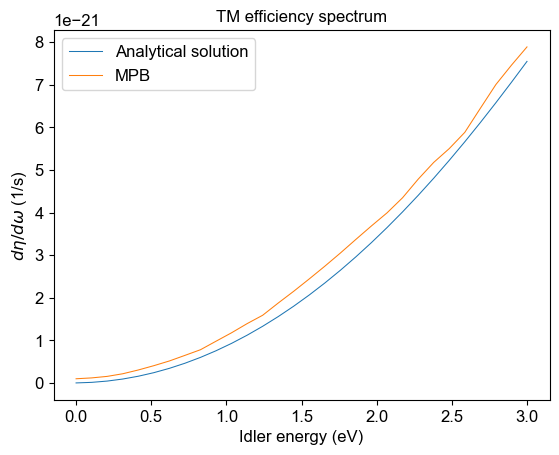

PyObject Text(29.000000000000007, 0.5, '$dη/dω$ (1/s)')

In [46]:
plot(ωrange, fspec_1d_fs_a_tm[1], label="Analytical solution")
plot(ωrange, fspec_fs_sc_tm, label="MPB")
legend()
title("TM efficiency spectrum")
xlabel("Idler energy (eV)")
ylabel(L"$dη/dω$ (1/s)")

### Bands for BCC and FCC lattice similarly messed up:

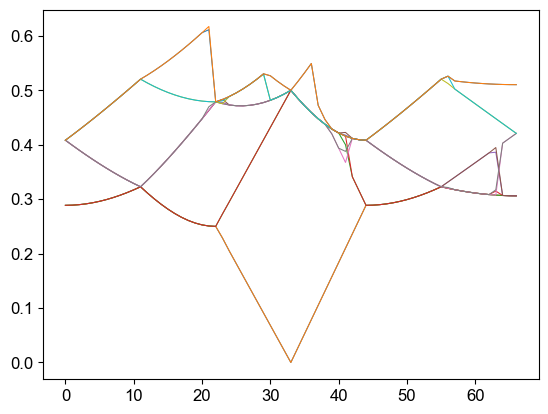

In [34]:
plot(npzread("phc_an_files/phc3d_fcc_fs_bands_e_12_12.npz")["arr_0"]);

In [1]:
plot(npzread("phc_an_files/phc3d_bcc_fs_bands_e_12_12.npz")["arr_0"]);

LoadError: UndefVarError: npzread not defined

## 3D PhCs from paper 

In [5]:
# data = npzread("phc3d_more_g.npz")
# data= npzread("phc3d_constant_eps.npz")
data = npzread("phc_an_files/phc3d_sc_sph_e_12_15_12b.npz")

kBZ = data["arr_0"]
Δk = kBZ[2] - kBZ[1]
# krange = -0.75:Δk:0.75
krange = -0.5:Δk:0.5

M1dat = data["arr_1"]
M2dat = data["arr_2"]
M3dat = data["arr_3"]
ωdat = data["arr_4"]
vgdat = data["arr_5"];

Nb = size(ωdat)[1]
NM = size(M1dat)[5]
Nk = size(ωdat)[2]
# ks = range(-0.75,0.75,length=70)
ks = range(-0.5,0.5,length=70)

ωsplines = Array{Any,1}(undef, Nb)
k0 = Integer((Nk+1)/2) # Nk must be odd

for b in 1:Nb
    # replace zeros with an average so we don't go into a bandgap...
    ωband = ωdat[b,:,:,:]
    ωitp = interpolate(ωband, BSpline(Quadratic(Flat(OnCell()))));
    ωsitp = scale(ωitp, krange, krange, krange);
    ωsplines[b] = ωsitp
end

Msplines = Array{Any,5}(undef, Nb, NM, NM, NM, 3)
for i in 1:3
    key = string("arr_", i)
    Mdat = data[key]
    for b in 1:Nb
        for nx in 1:NM
            for ny in 1:NM
                for nz in 1:NM
                    Mitp = interpolate(Mdat[b,:,:,:,nx,ny,nz], BSpline(Quadratic(Flat(OnCell()))));
                    Msitp = scale(Mitp, krange, krange, krange);
                    Msplines[b,nx,ny,nz,i] = Msitp
                end
            end
        end
    end
end

ωp = 1e19
ωi = 2e15
ωs = ωp - ωi
#dmnd and ln
# g = 3.1e10 #being approximate here
# ga
g = 1.95e10
gvec = g * [1,0,0]
θB = asin(g*c/(2*ωp))
# println(θB)

# χ = 2e-17 #dmmd
# χ = 1.3e-13 # LN
χ = 4.7e-14 # GA
np = 1e14
a = 0.5e-6 #PhC lattice spacing
L = 1e-4 #1mm where period is micron scale sounds reasonable

θdev = 0.0005
ϕdev = 0.0005

P = PumpBeam(1e19, θB, 0.0)
D_sc = PhC_Data(a, Msplines, ωsplines, 0);

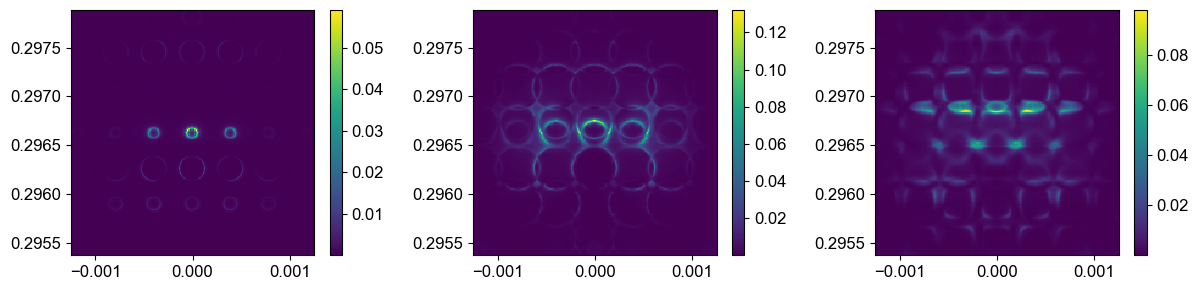

PyObject <matplotlib.colorbar.Colorbar object at 0x7f1148fe7890>

In [10]:
subplots(1, 3, figsize=(12, 3))
ωi = 0.75/ħeV #2/ħeV
Nangles = 200
θdev = 0.00125
ϕdev = 0.00125
ldat = zeros(Nangles,Nangles)
θrange = range(θB - θdev, θB + θdev, length=Nangles)
ϕrange = range(-ϕdev, ϕdev, length=Nangles)
Δθ = θrange[2]-θrange[1]
Δϕ = ϕrange[2]-ϕrange[1]

# noffset, k0_vec_no_unit, k_r, M0, ωi, lor, M02
Threads.@threads for b in 1:Nb
    newdat = [dΓdωdΩ_SC(ωp - ωi, θs, ϕs, gvec, P, D_sc, χ, np, L, b, 1, lz=0.4e14)*cos(θs)
                        for θs in θrange, ϕs in ϕrange]
    global ldat .+= newdat
end

# noffset, k0_vec_no_unit, M02, ωi, lor, Ep2, prefactor, kBvec, Msplines
# dat = [info_SC(ωp - ωi, θs, ϕs, gvec, P, D_sc, χ, np, L, 1, 1, lz=0.2e14)[3] for θs in θrange, ϕs in ϕrange]

subplot(1, 3, 1)
pcolormesh(ϕrange, θrange, ldat/2)
colorbar()

ωi = 1.3/ħeV
mdat = zeros(Nangles,Nangles)

Threads.@threads for b in 1:Nb
    newdat = [dΓdωdΩ_SC(ωp - ωi, θs, ϕs, gvec, P, D_sc, χ, np, L, b, 1, lz=0.4e14)*cos(θs)
                        for θs in θrange, ϕs in ϕrange]
    global mdat .+= newdat
end

subplot(1, 3, 2)
pcolormesh(ϕrange, θrange, mdat/2)
colorbar()

ωi = 1.6/ħeV
hdat = zeros(Nangles,Nangles)

Threads.@threads for b in 1:Nb
    newdat = [dΓdωdΩ_SC(ωp - ωi, θs, ϕs, gvec, P, D_sc, χ, np, L, b, 1, lz=0.4e14)*cos(θs)
                        for θs in θrange, ϕs in ϕrange]
    global hdat .+= newdat
end

subplot(1, 3, 3)
pcolormesh(ϕrange, θrange, hdat/2)
tight_layout()
colorbar()

In [11]:
npzwrite("phc_an_files/ang_spec_sc_ga_0-75_3_23_24.npz", ldat)
npzwrite("phc_an_files/ang_spec_sc_ga_1-3_3_23_24.npz", mdat)
npzwrite("phc_an_files/ang_spec_sc_ga_1-6_3_23_24.npz", hdat)

In [12]:
θdev = 0.0015
ϕdev = 0.0015

Nω = 80
Nangles = 100

θrange = range(θB - θdev, θB + θdev, length=Nangles)
ϕrange = range(-ϕdev, ϕdev, length=Nangles)
Δθ = θrange[2]-θrange[1]
Δϕ = ϕrange[2]-ϕrange[1]

ωirange = range(0.01/ħeV, 2.0/ħeV, length=Nω)
dηdω_sc = zeros(Nω)

for (i, ωi) in enumerate(ωirange)
    println("omega i = ", string(i))
    dat = zeros(Nangles, Nangles)
    Threads.@threads for b in 1:12 # CHANGED DUE TO MORE BANDS
        newdat = [dΓdωdΩ_SC(ωp - ωi, θs, ϕs, gvec, P, D_sc, χ, np, L, b)*cos(θs)
                            for θs in θrange, ϕs in ϕrange]
        global dat = dat .+ newdat
    end
    dηdω_sc[i] = sum(dat)*Δθ*Δϕ/(np*c*L^2)
end

omega i = 1
omega i = 2
omega i = 3
omega i = 4
omega i = 5
omega i = 6
omega i = 7
omega i = 8
omega i = 9
omega i = 10
omega i = 11
omega i = 12
omega i = 13
omega i = 14
omega i = 15
omega i = 16
omega i = 17
omega i = 18
omega i = 19
omega i = 20
omega i = 21
omega i = 22
omega i = 23
omega i = 24
omega i = 25
omega i = 26
omega i = 27
omega i = 28
omega i = 29
omega i = 30
omega i = 31
omega i = 32
omega i = 33
omega i = 34
omega i = 35
omega i = 36
omega i = 37
omega i = 38
omega i = 39
omega i = 40
omega i = 41
omega i = 42
omega i = 43
omega i = 44
omega i = 45
omega i = 46
omega i = 47
omega i = 48
omega i = 49
omega i = 50
omega i = 51
omega i = 52
omega i = 53
omega i = 54
omega i = 55
omega i = 56
omega i = 57
omega i = 58
omega i = 59
omega i = 60
omega i = 61
omega i = 62
omega i = 63
omega i = 64
omega i = 65
omega i = 66
omega i = 67
omega i = 68
omega i = 69
omega i = 70
omega i = 71
omega i = 72
omega i = 73
omega i = 74
omega i = 75
omega i = 76
omega i = 77
omega i 

In [15]:
ϵ_sc_sph = 1.72

dηdω_fs_sph = zeros(Nω)
dat = zeros(Nangles, Nangles)


for (i, ωi) in enumerate(ωirange)
    println("omega i = ", string(i))
    dat = [dΓdωdΩ_free(ωp - ωi, θs, ϕs, g*[0, 0, 1], P, ϵ_sc_sph, χ, np, L, pol="te", lz=1.2e14)*cos(θs) + 
           dΓdωdΩ_free(ωp - ωi, θs, ϕs, g*[0, 0, 1], P, ϵ_sc_sph, χ, np, L, pol="tm", lz=1.2e14)*cos(θs)
                        for θs in θrange, ϕs in ϕrange]
    dηdω_fs_sph[i] = sum(dat)*Δθ*Δϕ/(np*c*L^2)
end

omega i = 1
omega i = 2
omega i = 3
omega i = 4
omega i = 5
omega i = 6
omega i = 7
omega i = 8
omega i = 9
omega i = 10
omega i = 11
omega i = 12
omega i = 13
omega i = 14
omega i = 15
omega i = 16
omega i = 17
omega i = 18
omega i = 19
omega i = 20
omega i = 21
omega i = 22
omega i = 23
omega i = 24
omega i = 25
omega i = 26
omega i = 27
omega i = 28
omega i = 29
omega i = 30
omega i = 31
omega i = 32
omega i = 33
omega i = 34
omega i = 35
omega i = 36
omega i = 37
omega i = 38
omega i = 39
omega i = 40
omega i = 41
omega i = 42
omega i = 43
omega i = 44
omega i = 45
omega i = 46
omega i = 47
omega i = 48
omega i = 49
omega i = 50
omega i = 51
omega i = 52
omega i = 53
omega i = 54
omega i = 55
omega i = 56
omega i = 57
omega i = 58
omega i = 59
omega i = 60
omega i = 61
omega i = 62
omega i = 63
omega i = 64
omega i = 65
omega i = 66
omega i = 67
omega i = 68
omega i = 69
omega i = 70
omega i = 71
omega i = 72
omega i = 73
omega i = 74
omega i = 75
omega i = 76
omega i = 77
omega i 

In [22]:
dηdω_fs_sph_2 = dηdω_free(Nω, 2.0, ϵ_sc_sph, P, g*[0, 0, 1], χ, np, L; Nangles=100, lz=1.2e14, pol="te")[1]
.+ dηdω_free(Nω, 2.0, ϵ_sc_sph, P, g*[0, 0, 1], χ, np, L; Nangles=100, lz=1.2e14, pol="tm")[1]
 


omega i = 1
omega i = 2
omega i = 3
omega i = 4
omega i = 5
omega i = 6
omega i = 7
omega i = 8
omega i = 9
omega i = 10
omega i = 11
omega i = 12
omega i = 13
omega i = 14
omega i = 15
omega i = 16
omega i = 17
omega i = 18
omega i = 19
omega i = 20
omega i = 21
omega i = 22
omega i = 23
omega i = 24
omega i = 25
omega i = 26
omega i = 27
omega i = 28
omega i = 29
omega i = 30
omega i = 31
omega i = 32
omega i = 33
omega i = 34
omega i = 35
omega i = 36
omega i = 37
omega i = 38
omega i = 39
omega i = 40
omega i = 41
omega i = 42
omega i = 43
omega i = 44
omega i = 45
omega i = 46
omega i = 47
omega i = 48
omega i = 49
omega i = 50
omega i = 51
omega i = 52
omega i = 53
omega i = 54
omega i = 55
omega i = 56
omega i = 57
omega i = 58
omega i = 59
omega i = 60
omega i = 61
omega i = 62
omega i = 63
omega i = 64
omega i = 65
omega i = 66
omega i = 67
omega i = 68
omega i = 69
omega i = 70
omega i = 71
omega i = 72
omega i = 73
omega i = 74
omega i = 75
omega i = 76
omega i = 77
omega i 

80-element Array{Float64,1}:
 1.0275572409867973e-24
 4.094004342057377e-24
 8.011821407087939e-24
 1.2923759318113534e-23
 1.8850426468328982e-23
 2.5723559205116115e-23
 3.348790428170603e-23
 4.2189894193241685e-23
 5.1992583567502026e-23
 6.311923859816085e-23
 7.576979895523023e-23
 9.006102676317231e-23
 1.060184569873572e-22
 ⋮
 3.2483923423832093e-21
 3.3532063776858424e-21
 3.4590080810618344e-21
 3.5633037924985896e-21
 3.664742470445975e-21
 3.763356165169535e-21
 3.86025317928171e-21
 3.9572352003426766e-21
 4.0565662864878645e-21
 4.160702102718654e-21
 4.271667078889694e-21
 4.390073988294492e-21

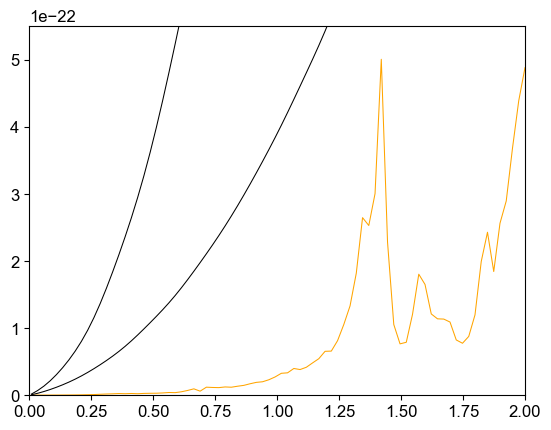

(0.0, 5.509274159952377e-22)

In [29]:
plot(ωirange*ħeV, dηdω_sc, color="orange")
plot(ωirange*ħeV, dηdω_fs_sph, color="black")
plot(ωirange*ħeV, dηdω_fs_sph_2, color="black")


xlim(0, 2.0)
ylim(0, 1.1*maximum(dηdω_sc))

In [27]:
npzwrite("phc_an_files/freq_spec_sc_ga_3_23_24.npz", dηdω_sc)

In [28]:
npzwrite("phc_an_files/freq_spec_sc_ga_fs_3_23_24.npz", dηdω_fs_sph_2)

## Woodpile GaAs

In [4]:
data = npzread("phc3d_wdpl_e_13_21_11-2-23.npz")
kBZ = data["arr_0"]
Δk = kBZ[2] - kBZ[1]
krange = -0.75:Δk:0.75

M1dat = data["arr_1"]
M2dat = data["arr_2"]
M3dat = data["arr_3"]
ωdat = data["arr_4"]
vgdat = data["arr_5"];

Nb = size(ωdat)[1]
NM = size(M1dat)[5]
Nk = size(ωdat)[2]
ks = range(-0.75,0.75,length=70)

ωsplines = Array{Any,1}(undef, Nb)
k0 = Integer((Nk+1)/2) # Nk must be odd

for b in 1:Nb
    ωband = ωdat[b,:,:,:]
    
    ωitp = interpolate(ωband, BSpline(Quadratic(Flat(OnCell()))));
    ωsitp = scale(ωitp, krange, krange, krange);
    ωsplines[b] = ωsitp
end

Msplines = Array{Any,5}(undef, Nb, NM, NM, NM, 3)
for i in 1:3
    key = string("arr_", i)
    Mdat = data[key]
    for b in 1:Nb
        for nx in 1:NM
            for ny in 1:NM
                for nz in 1:NM
                    Mitp = interpolate(Mdat[b,:,:,:,nx,ny,nz], BSpline(Quadratic(Flat(OnCell()))));
                    Msitp = scale(Mitp, krange, krange, krange);
                    Msplines[b,nx,ny,nz,i] = Msitp
                end
            end
        end
    end
end

ωp = 1e19
ωi = 2e15
ωs = ωp - ωi
#dmnd and ln
# g = 3.1e10 #being approximate here
# ga
g = 1.95e10
gvec = g * [1,0,0]
θB = asin(g*c/(2*ωp))
# println(θB)

# χ = 2e-17 #dmmd
# χ = 1.3e-13 # LN
χ = 4.7e-14 # GA
np = 1e14
a = 0.5e-6 #PhC lattice spacing
# a = 0.8e-8 # free space lattice spacing.... get more accurate modes??
L = 1e-4 #1mm where period is micron scale sounds reasonable

θdev = 0.0005
ϕdev = 0.0005

P = PumpBeam(1e19, θB, 0.0)
D_wdpl_ga = PhC_Data(a, Msplines, ωsplines, 0);

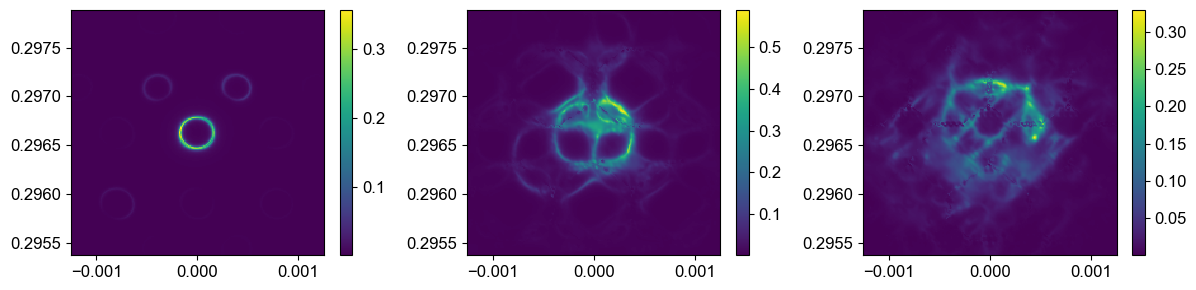

PyObject <matplotlib.colorbar.Colorbar object at 0x7fe5f4df7f50>

In [10]:
subplots(1, 3, figsize=(12, 3))
ωi = 0.7/ħeV #2/ħeV
Nangles = 200
θdev = 0.00125
ϕdev = 0.00125
ldat = zeros(Nangles,Nangles)
θrange = range(θB - θdev, θB + θdev, length=Nangles)
ϕrange = range(-ϕdev, ϕdev, length=Nangles)
Δθ = θrange[2]-θrange[1]
Δϕ = ϕrange[2]-ϕrange[1]

# noffset, k0_vec_no_unit, k_r, M0, ωi, lor, M02
Threads.@threads for b in 1:Nb
    newdat = [dΓdωdΩ_stitch_FCC(ωp - ωi, θs, ϕs, gvec, P, D_wdpl_ga, χ, np, L, b, 1, lz=0.4e14)*cos(θs)
                        for θs in θrange, ϕs in ϕrange]
    global ldat .+= newdat
end

# noffset, k0_vec_no_unit, M02, ωi, lor, Ep2, prefactor, kBvec, Msplines
# dat = [info_SC(ωp - ωi, θs, ϕs, gvec, P, D_sc, χ, np, L, 1, 1, lz=0.2e14)[3] for θs in θrange, ϕs in ϕrange]

subplot(1, 3, 1)
pcolormesh(ϕrange, θrange, ldat/2)
colorbar()

ωi = 1.6/ħeV
mdat = zeros(Nangles,Nangles)

Threads.@threads for b in 1:Nb
    newdat = [dΓdωdΩ_stitch_FCC(ωp - ωi, θs, ϕs, gvec, P, D_wdpl_ga, χ, np, L, b, 1, lz=0.4e14)*cos(θs)
                        for θs in θrange, ϕs in ϕrange]
    global mdat .+= newdat
end

subplot(1, 3, 2)
pcolormesh(ϕrange, θrange, mdat/2)
colorbar()

ωi = 2.0/ħeV
hdat = zeros(Nangles,Nangles)

Threads.@threads for b in 1:Nb
    newdat = [dΓdωdΩ_stitch_FCC(ωp - ωi, θs, ϕs, gvec, P, D_wdpl_ga, χ, np, L, b, 1, lz=0.4e14)*cos(θs)
                        for θs in θrange, ϕs in ϕrange]
    global hdat .+= newdat
end

subplot(1, 3, 3)
pcolormesh(ϕrange, θrange, hdat/2)
tight_layout()
colorbar()

In [11]:
npzwrite("phc_an_files/ang_spec_wdpl_ga_thrange_200.npz", θrange)
npzwrite("phc_an_files/ang_spec_wdpl_ga_phrange_200.npz", ϕrange)

In [35]:
npzwrite("phc_an_files/ang_spec_wdpl_ga_0-7_4_10_24.npz", ldat)
npzwrite("phc_an_files/ang_spec_wdpl_ga_1-6_4_10_24.npz", mdat)
npzwrite("phc_an_files/ang_spec_wdpl_ga_2-0_4_10_24.npz", hdat)

In [26]:
θdev = 0.0015
ϕdev = 0.0015

Nω = 150
Nangles = 100

θrange = range(θB - θdev, θB + θdev, length=Nangles)
ϕrange = range(-ϕdev, ϕdev, length=Nangles)
Δθ = θrange[2]-θrange[1]
Δϕ = ϕrange[2]-ϕrange[1]

ωirange = range(0.01/ħeV, 2.2/ħeV, length=Nω)
dηdω_wdpl = zeros(Nω)

for (i, ωi) in enumerate(ωirange)
    println("omega i = ", string(i))
    dat = zeros(Nangles, Nangles)
    Threads.@threads for b in 1:12 # CHANGED DUE TO MORE BANDS
        newdat = [dΓdωdΩ_stitch_FCC(ωp - ωi, θs, ϕs, gvec, P, D_wdpl_ga, χ, np, L, b, lz=0.8e14)*cos(θs)
                            for θs in θrange, ϕs in ϕrange]
        global dat = dat .+ newdat
    end
    dηdω_wdpl[i] = sum(dat)*Δθ*Δϕ/(np*c*L^2)
end

omega i = 1
omega i = 2
omega i = 3
omega i = 4
omega i = 5
omega i = 6
omega i = 7
omega i = 8
omega i = 9
omega i = 10
omega i = 11
omega i = 12
omega i = 13
omega i = 14
omega i = 15
omega i = 16
omega i = 17
omega i = 18
omega i = 19
omega i = 20
omega i = 21
omega i = 22
omega i = 23
omega i = 24
omega i = 25
omega i = 26
omega i = 27
omega i = 28
omega i = 29
omega i = 30
omega i = 31
omega i = 32
omega i = 33
omega i = 34
omega i = 35
omega i = 36
omega i = 37
omega i = 38
omega i = 39
omega i = 40
omega i = 41
omega i = 42
omega i = 43
omega i = 44
omega i = 45
omega i = 46
omega i = 47
omega i = 48
omega i = 49
omega i = 50
omega i = 51
omega i = 52
omega i = 53
omega i = 54
omega i = 55
omega i = 56
omega i = 57
omega i = 58
omega i = 59
omega i = 60
omega i = 61
omega i = 62
omega i = 63
omega i = 64
omega i = 65
omega i = 66
omega i = 67
omega i = 68
omega i = 69
omega i = 70
omega i = 71
omega i = 72
omega i = 73
omega i = 74
omega i = 75
omega i = 76
omega i = 77
omega i 

In [14]:
gvec

3-element Array{Float64,1}:
 1.95e10
 0.0
 0.0

In [15]:
fspec_fs_a_tm = dηdω_free(120, 2.2, 12, P, g * [0, 0, 1], χ, np, L, Nangles=100, lz=1.6e14, θdev=0.00175, ϕdev=0.00175, pol="tm")
fspec_fs_a_te = dηdω_free(120, 2.2, 12, P, g * [0, 0, 1], χ, np, L, Nangles=100, lz=1.6e14, θdev=0.00175, ϕdev=0.00175, pol="te")

omega i = 1
omega i = 2
omega i = 3
omega i = 4
omega i = 5
omega i = 6
omega i = 7
omega i = 8
omega i = 9
omega i = 10
omega i = 11
omega i = 12
omega i = 13
omega i = 14
omega i = 15
omega i = 16
omega i = 17
omega i = 18
omega i = 19
omega i = 20
omega i = 21
omega i = 22
omega i = 23
omega i = 24
omega i = 25
omega i = 26
omega i = 27
omega i = 28
omega i = 29
omega i = 30
omega i = 31
omega i = 32
omega i = 33
omega i = 34
omega i = 35
omega i = 36
omega i = 37
omega i = 38
omega i = 39
omega i = 40
omega i = 41
omega i = 42
omega i = 43
omega i = 44
omega i = 45
omega i = 46
omega i = 47
omega i = 48
omega i = 49
omega i = 50
omega i = 51
omega i = 52
omega i = 53
omega i = 54
omega i = 55
omega i = 56
omega i = 57
omega i = 58
omega i = 59
omega i = 60
omega i = 61
omega i = 62
omega i = 63
omega i = 64
omega i = 65
omega i = 66
omega i = 67
omega i = 68
omega i = 69
omega i = 70
omega i = 71
omega i = 72
omega i = 73
omega i = 74
omega i = 75
omega i = 76
omega i = 77
omega i 

([8.574176477653348e-25, 2.6228411531214233e-24, 4.649503141074233e-24, 6.957886130886214e-24, 9.568862355576096e-24, 1.2501144516184233e-23, 1.5769620891594034e-23, 1.9387438094394937e-23, 2.3366275205503066e-23, 2.771372911396085e-23  …  2.540743408936832e-21, 2.5859060474286816e-21, 2.6314701952949962e-21, 2.677366642676958e-21, 2.7236082312438346e-21, 2.7702620684853036e-21, 2.817298625446487e-21, 2.8646503951390818e-21, 2.9123548198220227e-21, 2.9604688125482694e-21], [0.001415512023052614 0.00149843149893787 … 0.00149843149893787 0.001415512023052614; 0.0014417222264410479 0.0015284439643983051 … 0.0015284439643983051 0.0014417222264410479; … ; 0.0011349199290618022 0.0012031604460357905 … 0.0012031604460357905 0.0011349199290618022; 0.001119628996375268 0.0011851886990838338 … 0.0011851886990838338 0.001119628996375268], 3.535353535355501e-5, 3.6968020057221145e-5, 0.2948780647924133:3.5353535353534824e-5:0.29837806479241324)

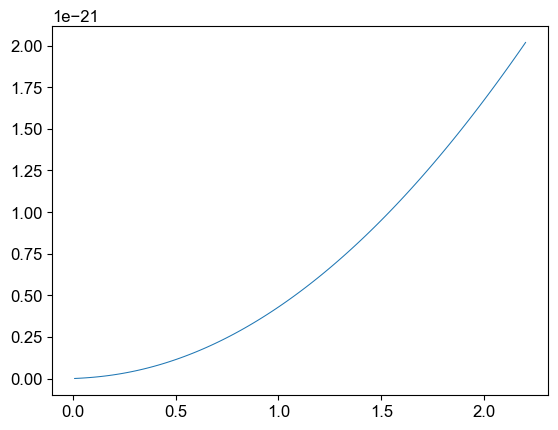

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fe3d8d124d0>

In [30]:
ωirange_fs = range(0.01/ħeV, 2.2/ħeV, length=120)
plot(ωirange_fs*ħeV, (fspec_fs_a_tm[1] .+ fspec_fs_a_te[1]) * 0.29)

In [22]:
npzwrite("phc_an_files/freq_spec_wdpl_ga_fs_4_22_24.npz", fspec_fs_a_tm[1] .+ fspec_fs_a_te[1])

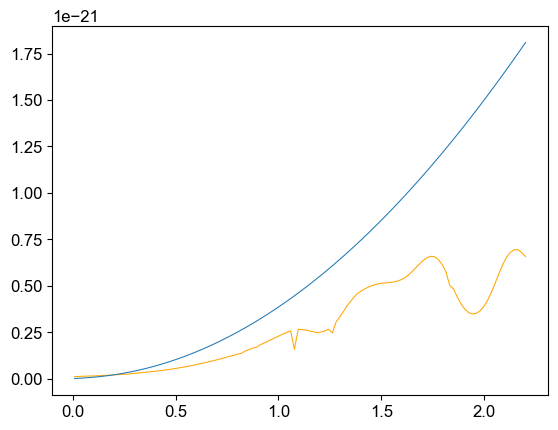

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fe5f3b7d2d0>

In [46]:
plot(ωirange*ħeV, dηdω_wdpl, color="orange")
plot(ωirange_fs*ħeV, (fspec_fs_a_tm[1] .+ fspec_fs_a_te[1]) * 0.26)

In [25]:
npzwrite("phc_an_files/freq_spec_wdpl_ga_4_23_24.npz", dηdω_wdpl)

# Inverse opal GA

In [32]:
data = npzread("phc_an_files/phc3d_iop_ga_4_23_24.npz")
kBZ = data["arr_0"]
Δk = kBZ[2] - kBZ[1]
krange = -0.75:Δk:0.75

M1dat = data["arr_1"]
M2dat = data["arr_2"]
M3dat = data["arr_3"]
ωdat = data["arr_4"]
vgdat = data["arr_5"];

Nb = size(ωdat)[1]
NM = size(M1dat)[5]
Nk = size(ωdat)[2]
ks = range(-0.75,0.75,length=70)

ωsplines = Array{Any,1}(undef, Nb)
k0 = Integer((Nk+1)/2) # Nk must be odd

for b in 1:Nb
    ωband = ωdat[b,:,:,:]
    
    ωitp = interpolate(ωband, BSpline(Quadratic(Flat(OnCell()))));
    ωsitp = scale(ωitp, krange, krange, krange);
    ωsplines[b] = ωsitp
end

Msplines = Array{Any,5}(undef, Nb, NM, NM, NM, 3)
for i in 1:3
    key = string("arr_", i)
    Mdat = data[key]
    for b in 1:Nb
        for nx in 1:NM
            for ny in 1:NM
                for nz in 1:NM
                    Mitp = interpolate(Mdat[b,:,:,:,nx,ny,nz], BSpline(Quadratic(Flat(OnCell()))));
                    Msitp = scale(Mitp, krange, krange, krange);
                    Msplines[b,nx,ny,nz,i] = Msitp
                end
            end
        end
    end
end

ωp = 1e19
ωi = 2e15
ωs = ωp - ωi
#dmnd and ln
# g = 3.1e10 #being approximate here
# ga
g = 1.95e10
gvec = g * [1,0,0]
θB = asin(g*c/(2*ωp))
# println(θB)

# χ = 2e-17 #dmmd
# χ = 1.3e-13 # LN
χ = 4.7e-14 # GA
np = 1e14
a = 0.5e-6 #PhC lattice spacing
# a = 0.8e-8 # free space lattice spacing.... get more accurate modes??
L = 1e-4 #1mm where period is micron scale sounds reasonable

θdev = 0.0005
ϕdev = 0.0005

P = PumpBeam(1e19, θB, 0.0)
D_iop_ga = PhC_Data(a, Msplines, ωsplines, 0);

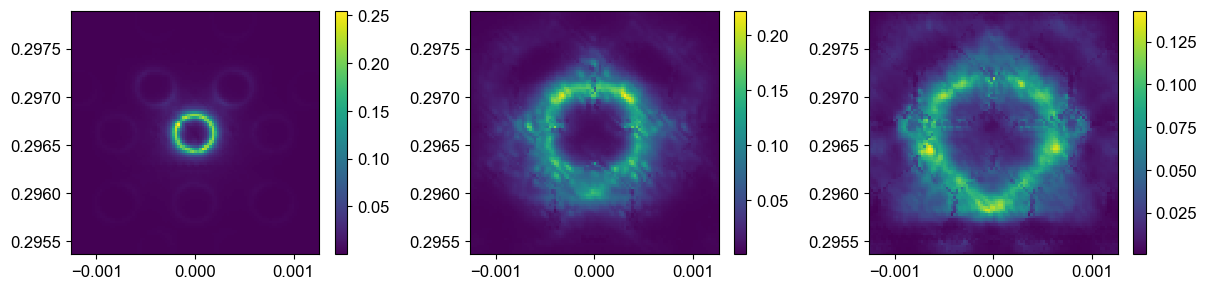

PyObject <matplotlib.colorbar.Colorbar object at 0x7fe5f3597150>

In [40]:
subplots(1, 3, figsize=(12, 3))
ωi = 0.8/ħeV #2/ħeV
Nangles = 100
θdev = 0.00125
ϕdev = 0.00125
ldat = zeros(Nangles,Nangles)
θrange = range(θB - θdev, θB + θdev, length=Nangles)
ϕrange = range(-ϕdev, ϕdev, length=Nangles)
Δθ = θrange[2]-θrange[1]
Δϕ = ϕrange[2]-ϕrange[1]

# noffset, k0_vec_no_unit, k_r, M0, ωi, lor, M02
Threads.@threads for b in 1:Nb
    newdat = [dΓdωdΩ_stitch_FCC(ωp - ωi, θs, ϕs, gvec, P, D_iop_ga, χ, np, L, b, 1, lz=1.4e14)*cos(θs)
                        for θs in θrange, ϕs in ϕrange]
    global ldat .+= newdat
end

# noffset, k0_vec_no_unit, M02, ωi, lor, Ep2, prefactor, kBvec, Msplines
# dat = [info_SC(ωp - ωi, θs, ϕs, gvec, P, D_sc, χ, np, L, 1, 1, lz=0.2e14)[3] for θs in θrange, ϕs in ϕrange]

subplot(1, 3, 1)
pcolormesh(ϕrange, θrange, ldat)
colorbar()

ωi = 1.7/ħeV
mdat = zeros(Nangles,Nangles)

Threads.@threads for b in 1:Nb
    newdat = [dΓdωdΩ_stitch_FCC(ωp - ωi, θs, ϕs, gvec, P, D_iop_ga, χ, np, L, b, 1, lz=1.4e14)*cos(θs)
                        for θs in θrange, ϕs in ϕrange]
    global mdat .+= newdat
end

subplot(1, 3, 2)
pcolormesh(ϕrange, θrange, mdat)
colorbar()

ωi = 2.1/ħeV
hdat = zeros(Nangles,Nangles)

Threads.@threads for b in 1:Nb
    newdat = [dΓdωdΩ_stitch_FCC(ωp - ωi, θs, ϕs, gvec, P, D_iop_ga, χ, np, L, b, 1, lz=1.4e14)*cos(θs)
                        for θs in θrange, ϕs in ϕrange]
    global hdat .+= newdat
end

subplot(1, 3, 3)
pcolormesh(ϕrange, θrange, hdat)
tight_layout()
colorbar()

In [41]:
sum(ldat)

61.447837092995

In [42]:
sum(mdat)

290.03807551899854

In [43]:
sum(hdat)

285.90182418080144

In [44]:
θdev = 0.0015
ϕdev = 0.0015

Nω = 120
Nangles = 100

θrange = range(θB - θdev, θB + θdev, length=Nangles)
ϕrange = range(-ϕdev, ϕdev, length=Nangles)
Δθ = θrange[2]-θrange[1]
Δϕ = ϕrange[2]-ϕrange[1]

ωirange = range(0.01/ħeV, 2.2/ħeV, length=Nω)
dηdω_wdpl = zeros(Nω)

for (i, ωi) in enumerate(ωirange)
    println("omega i = ", string(i))
    dat = zeros(Nangles, Nangles)
    Threads.@threads for b in 1:12
        newdat = [dΓdωdΩ_stitch_FCC(ωp - ωi, θs, ϕs, gvec, P, D_iop_ga, χ, np, L, b, lz=1.4e14)*cos(θs)
                            for θs in θrange, ϕs in ϕrange]
        global dat = dat .+ newdat
    end
    dηdω_wdpl[i] = sum(dat)*Δθ*Δϕ/(np*c*L^2)
end

omega i = 1
omega i = 2
omega i = 3
omega i = 4
omega i = 5
omega i = 6
omega i = 7
omega i = 8
omega i = 9
omega i = 10
omega i = 11
omega i = 12
omega i = 13
omega i = 14
omega i = 15
omega i = 16
omega i = 17
omega i = 18
omega i = 19
omega i = 20
omega i = 21
omega i = 22
omega i = 23
omega i = 24
omega i = 25
omega i = 26
omega i = 27
omega i = 28
omega i = 29
omega i = 30
omega i = 31
omega i = 32
omega i = 33
omega i = 34
omega i = 35
omega i = 36
omega i = 37
omega i = 38
omega i = 39
omega i = 40
omega i = 41
omega i = 42
omega i = 43
omega i = 44
omega i = 45
omega i = 46
omega i = 47
omega i = 48
omega i = 49
omega i = 50
omega i = 51
omega i = 52
omega i = 53
omega i = 54
omega i = 55
omega i = 56
omega i = 57
omega i = 58
omega i = 59
omega i = 60
omega i = 61
omega i = 62
omega i = 63
omega i = 64
omega i = 65
omega i = 66
omega i = 67
omega i = 68
omega i = 69
omega i = 70
omega i = 71
omega i = 72
omega i = 73
omega i = 74
omega i = 75
omega i = 76
omega i = 77
omega i 

In [50]:
fspec_fs_a_tm_4 = dηdω_free(120, 2.2, 4.3, P, g * [0, 0, 1], χ, np, L, Nangles=100, lz=1.6e14, θdev=0.00175, ϕdev=0.00175, pol="tm")
fspec_fs_a_te_4 = dηdω_free(120, 2.2, 4.3, P, g * [0, 0, 1], χ, np, L, Nangles=100, lz=1.6e14, θdev=0.00175, ϕdev=0.00175, pol="te")

omega i = 1
omega i = 2
omega i = 3
omega i = 4
omega i = 5
omega i = 6
omega i = 7
omega i = 8
omega i = 9
omega i = 10
omega i = 11
omega i = 12
omega i = 13
omega i = 14
omega i = 15
omega i = 16
omega i = 17
omega i = 18
omega i = 19
omega i = 20
omega i = 21
omega i = 22
omega i = 23
omega i = 24
omega i = 25
omega i = 26
omega i = 27
omega i = 28
omega i = 29
omega i = 30
omega i = 31
omega i = 32
omega i = 33
omega i = 34
omega i = 35
omega i = 36
omega i = 37
omega i = 38
omega i = 39
omega i = 40
omega i = 41
omega i = 42
omega i = 43
omega i = 44
omega i = 45
omega i = 46
omega i = 47
omega i = 48
omega i = 49
omega i = 50
omega i = 51
omega i = 52
omega i = 53
omega i = 54
omega i = 55
omega i = 56
omega i = 57
omega i = 58
omega i = 59
omega i = 60
omega i = 61
omega i = 62
omega i = 63
omega i = 64
omega i = 65
omega i = 66
omega i = 67
omega i = 68
omega i = 69
omega i = 70
omega i = 71
omega i = 72
omega i = 73
omega i = 74
omega i = 75
omega i = 76
omega i = 77
omega i 

([9.753133603080259e-25, 2.957305553874989e-24, 5.1843528682049705e-24, 7.652183030006797e-24, 1.035994367588133e-23, 1.3321264053095653e-23, 1.6564134864963458e-23, 2.011834619233294e-23, 2.3999496357787226e-23, 2.8202075587677076e-23  …  2.276704172010971e-21, 2.3167614782153634e-21, 2.357821914414722e-21, 2.3998865271629612e-21, 2.4424623252777474e-21, 2.484969809452878e-21, 2.527170290938523e-21, 2.569303382628799e-21, 2.611901651627694e-21, 2.6554382325614376e-21], [0.0007812384325404696 0.0008191167926453812 … 0.0008191167926453812 0.0007812384325404696; 0.0007881187385665287 0.000827212928595051 … 0.000827212928595051 0.0007881187385665287; … ; 0.0006202459133812795 0.0006509980774254788 … 0.0006509980774254788 0.0006202459133812795; 0.0006177819195051194 0.000647720014349957 … 0.000647720014349957 0.0006177819195051194], 3.535353535355501e-5, 3.6968020057221145e-5, 0.2948780647924133:3.5353535353534824e-5:0.29837806479241324)

In [51]:
fspec_fs_a_tm_13 = dηdω_free(120, 2.2, 3, P, g * [0, 0, 1], χ, np, L, Nangles=100, lz=1.6e14, θdev=0.00175, ϕdev=0.00175, pol="tm")
fspec_fs_a_te_13 = dηdω_free(120, 2.2, 3, P, g * [0, 0, 1], χ, np, L, Nangles=100, lz=1.6e14, θdev=0.00175, ϕdev=0.00175, pol="te")

omega i = 1
omega i = 2
omega i = 3
omega i = 4
omega i = 5
omega i = 6
omega i = 7
omega i = 8
omega i = 9
omega i = 10
omega i = 11
omega i = 12
omega i = 13
omega i = 14
omega i = 15
omega i = 16
omega i = 17
omega i = 18
omega i = 19
omega i = 20
omega i = 21
omega i = 22
omega i = 23
omega i = 24
omega i = 25
omega i = 26
omega i = 27
omega i = 28
omega i = 29
omega i = 30
omega i = 31
omega i = 32
omega i = 33
omega i = 34
omega i = 35
omega i = 36
omega i = 37
omega i = 38
omega i = 39
omega i = 40
omega i = 41
omega i = 42
omega i = 43
omega i = 44
omega i = 45
omega i = 46
omega i = 47
omega i = 48
omega i = 49
omega i = 50
omega i = 51
omega i = 52
omega i = 53
omega i = 54
omega i = 55
omega i = 56
omega i = 57
omega i = 58
omega i = 59
omega i = 60
omega i = 61
omega i = 62
omega i = 63
omega i = 64
omega i = 65
omega i = 66
omega i = 67
omega i = 68
omega i = 69
omega i = 70
omega i = 71
omega i = 72
omega i = 73
omega i = 74
omega i = 75
omega i = 76
omega i = 77
omega i 

([1.0149355526129848e-24, 3.0696614919479843e-24, 5.364625863762435e-24, 7.886283195680469e-24, 1.06185635351795e-23, 1.355594349489485e-23, 1.671149079561973e-23, 2.0115215123725338e-23, 2.3803727362776697e-23, 2.780624755299923e-23  …  2.0681666528008923e-21, 2.1061254614258017e-21, 2.14393748161994e-21, 2.1812371025580084e-21, 2.218037109816853e-21, 2.254779507982801e-21, 2.292153056828954e-21, 2.3307416887422784e-21, 2.3706940812490096e-21, 2.4116146248435867e-21], [0.0006910993425017405 0.0007234167883505817 … 0.0007234167883505817 0.0006910993425017405; 0.0006960406432633486 0.0007293218798653589 … 0.0007293218798653589 0.0006960406432633486; … ; 0.0005477568263138385 0.0005739349093435757 … 0.0005739349093435757 0.0005477568263138385; 0.0005464788014095932 0.0005720202408811875 … 0.0005720202408811875 0.0005464788014095932], 3.535353535355501e-5, 3.6968020057221145e-5, 0.2948780647924133:3.5353535353534824e-5:0.29837806479241324)

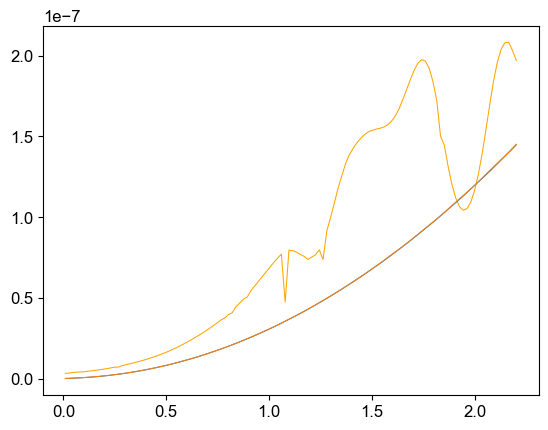

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fe5f33b7b10>

In [56]:
plot(ωirange*ħeV, dηdω_wdpl* np * c * L^2, color="orange")
plot(ωirange_fs*ħeV, (fspec_fs_a_tm_4[1] .+ fspec_fs_a_te_4[1]) * 0.26^2 * np * c * L^2)
plot(ωirange_fs*ħeV, (fspec_fs_a_tm_13[1] .+ fspec_fs_a_te_13[1]) * 0.26^2* np * c * L^2)